Output the number of used nodes

In [22]:
import pandas as pd

path = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/2023_cpu/fabing_cpu_250_20_7/05-BestFit/1.3/42/analysis_allo.csv'
df = pd.read_csv(path)

df.columns = [x.split('-')[-1] for x in df.columns]
dfd = df.to_dict(orient="list")
print(dfd['used_nodes'])
print(max(df['used_nodes']))
total_gpu_num = df.total_gpus.values[0]
df['arrive_ratio'] = df.arrived_gpu_milli / total_gpu_num / 10
df['arrive_ratio'] = df['arrive_ratio'].apply(lambda x: round(x, 0))
df['alloc_ratio'] = df.used_gpu_milli / total_gpu_num / 10
df['alloc_ratio'] = df['alloc_ratio'].apply(lambda x: round(x, 2))

[1, 0, 1, 0, 1, 2, 3, 2, 3, 4, 3, 2, 3, 4, 5, 5, 4, 4, 3, 2, 3, 2, 3, 3, 3, 4, 3, 4, 5, 6, 6, 6, 5, 5, 4, 4, 3, 2, 3, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 3, 2, 3, 4, 5, 5, 5, 6, 5, 6, 7, 6, 5, 4, 3, 4, 3, 3, 3, 3, 3, 4, 5, 4, 3, 2, 2, 2, 2, 3, 4, 5, 4, 5, 6, 6, 6, 6, 6, 7, 6, 6, 5, 5, 5, 6, 7, 6, 7, 8, 7, 6, 7, 8, 7, 7, 6, 6, 5, 4, 4, 5, 4, 4, 4, 5, 5, 4, 3, 4, 3, 4, 3, 4, 4, 3, 4, 3, 4, 5, 4, 4, 5, 6, 5, 6, 5, 6, 7, 6, 7, 8, 7, 6, 7, 8, 9, 10, 11, 11, 11, 12, 11, 11, 12, 11, 10, 9, 10, 9, 8, 7, 6, 7, 6, 7, 6, 7, 8, 7, 8, 7, 8, 7, 8, 8, 9, 9, 9, 9, 8, 7, 8, 9, 8, 7, 8, 9, 8, 9, 10, 11, 10, 11, 10, 11, 12, 11, 10, 10, 11, 12, 11, 10, 9, 10, 10, 9, 10, 9, 10, 11, 11, 11, 10, 10, 9, 8, 9, 10, 9, 8, 7, 8, 7, 8, 7, 8, 7, 8, 7, 8, 9, 8, 7, 7, 6, 5, 4, 5, 5, 6, 5, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 3, 3, 4, 5, 4, 5, 4, 3, 4, 3, 4, 5, 4, 5, 4, 4, 4, 4, 5, 5, 5, 5, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 7, 8, 7, 6, 7, 7, 7, 7, 7, 8, 7, 8, 9, 9, 9, 10, 10, 9,

Further processing of analysis results

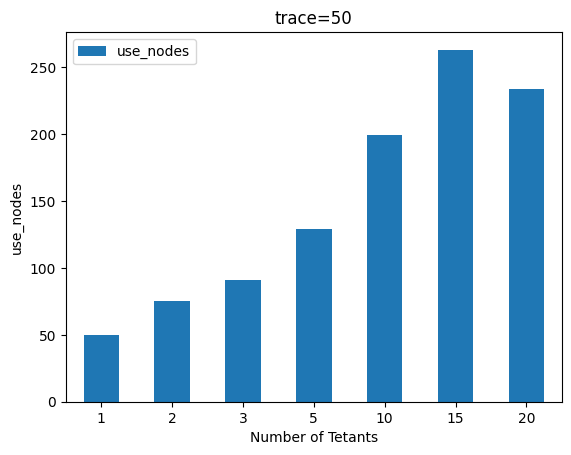

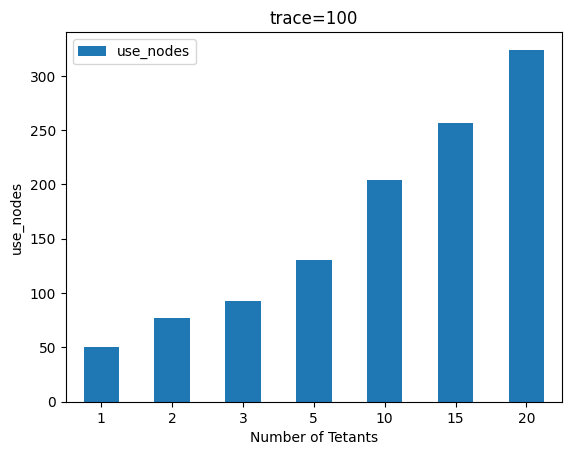

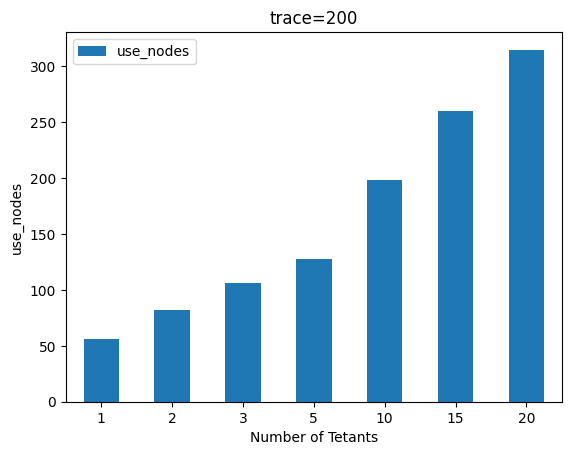

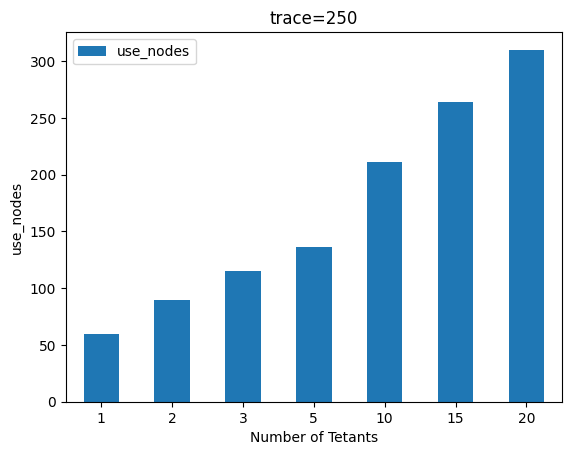

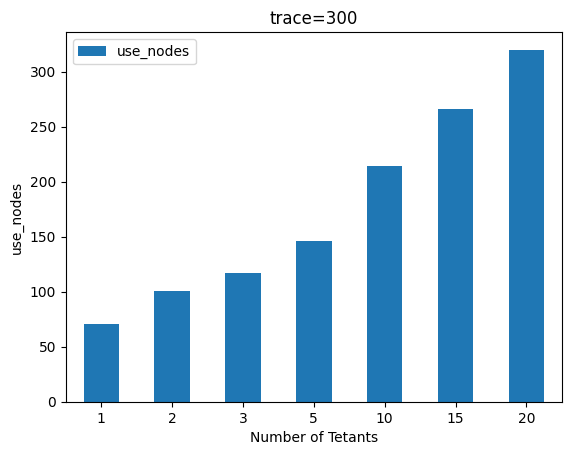

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_allo_discrete_sum_use_nodes_uniform.csv'
# Load the dataframe from the CSV file
# df = pd.read_csv('/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_allo_discrete.csv')
df = pd.read_csv('/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_allo_discrete.csv')
df.drop(columns=['sc_policy', 'tune', 'seed'], inplace=True)

# Group by 'workload' and calculate the mean of the other columns
df = df.groupby('workload').mean()
# Reset the index
df = df.reset_index()
# Extract the prefix of the 'workload' column
df['workload_prefix'] = df['workload'].str.rsplit('_', n=1).str[0]

# Calculate the average 'use_nodes' for each 'workload_prefix'
average_use_nodes = df.groupby('workload_prefix')['use_nodes'].sum()
average_use_nodes.to_csv(out_file)
df = pd.read_csv(out_file)
# Split the 'workload_prefix' into four parts
df[['prefix', 'cpu', 'first_number', 'second_number']] = df['workload_prefix'].str.split('_', n=3, expand=True)

# Convert the 'first_number' and 'second_number' columns to numeric types
df[['first_number', 'second_number']] = df[['first_number', 'second_number']].apply(pd.to_numeric)

# Group by 'first_number' and calculate the mean of 'use_nodes'
grouped_df = df.groupby('first_number')['use_nodes'].mean()

# Sort by 'second_number'
sorted_df = df.sort_values('first_number')

# Draw bar charts
for i in sorted_df['first_number'].unique():
    # Filter the dataframe
    filtered_df = sorted_df[sorted_df['first_number'] == i]
    # Sort by 'second_number'
    filtered_df = filtered_df.sort_values('second_number')
    # Draw a bar chart
    filtered_df.plot.bar(x='second_number', y='use_nodes', rot=0, title=f'trace={i}', xlabel='Number of Tetants', ylabel='use_nodes')
    plt.show()

# Save to a new CSV file
# print(sorted_df)
# sorted_df.to_csv(out_file)


filter the node config according to 'memory' and 'cpu'

In [6]:
import pandas as pd

# Load the dataframe from the CSV file
path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_node_list_all_node.csv'
df = pd.read_csv(path)
print(df['cpu_milli'].mean()/1000)
print(df['memory_mib'].mean()/1024)
# Remove columns ['sn', 'gpu', 'model']
# df = df.drop(columns=['sn', 'gpu', 'model'])

# # Remove duplicate rows
# df = df.drop_duplicates()

# # Save to a new CSV file
# df.to_csv('/home/fabing/projects/kubernetes-scheduler-simulator/simplify_node_list_all_node.csv', index=False)
# print(df)


82.41234405778069
392.43860801050556


# Sample Traces

## sequentially split the trace

In [ ]:
import pandas as pd
import numpy as np


nums = ['050', '100', '200', '250', '300']
for num in nums:
    path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu' + num + '.csv'
    df = pd.read_csv(path)
    df['num_gpu'] = 0
    df['gpu_milli'] = 0
    df['gpu_spec'] = ''
    running_df = df
    # Filter the dataframe
    # running_df = df[df['pod_phase'] == 'Running']
    # running_df = running_df[running_df['qos'] == 'LS']
    running_df = running_df[running_df['num_gpu'] == 0]
    
    # Prepend '16' to 'creation_time' and 'deletion_time'
    # running_df['creation_time'] = running_df['creation_time'].apply(lambda x: '16' + str(x))
    # running_df['deletion_time'] = running_df['deletion_time'].apply(lambda x: '16' + str(x))
    # # running_df['scheduled_time'] = running_df['scheduled_time'].apply(lambda x: '16' + str(x))
    # # Convert 'creation_time' and 'deletion_time' to datetime
    # running_df['creation_time'] = pd.to_datetime(running_df['creation_time'], unit='s')
    # running_df['deletion_time'] = pd.to_datetime(running_df['deletion_time'], unit='s')
    # # running_df['scheduled_time'] = pd.to_datetime(running_df['scheduled_time'], unit='s')

    # # Convert datetime to RFC3339 format
    # running_df['creation_time'] = running_df['creation_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    # running_df['deletion_time'] = running_df['deletion_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    # running_df['scheduled_time'] = running_df['scheduled_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    tenants = [1, 2, 3, 5, 10, 15, 20]
    for tenant in tenants:
        # Split the dataframe into parts
        dfs = np.array_split(running_df, tenant)
        # Save each part to a separate CSV file
        for i, df_part in enumerate(dfs, 1):
            out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/data/origin_csv/fabing_cpu_{}_{}_{}.csv'.format(num, tenant, i)
            print('data/fabing_cpu_{}_{}_{}'.format(num, tenant, i))
            df_part.to_csv(out_file.format(i), index=False)


data/fabing_cpu_050_1_1
data/fabing_cpu_050_2_1
data/fabing_cpu_050_2_2
data/fabing_cpu_050_3_1
data/fabing_cpu_050_3_2
data/fabing_cpu_050_3_3
data/fabing_cpu_050_5_1
data/fabing_cpu_050_5_2
data/fabing_cpu_050_5_3
data/fabing_cpu_050_5_4
data/fabing_cpu_050_5_5
data/fabing_cpu_050_10_1
data/fabing_cpu_050_10_2
data/fabing_cpu_050_10_3
data/fabing_cpu_050_10_4
data/fabing_cpu_050_10_5
data/fabing_cpu_050_10_6
data/fabing_cpu_050_10_7
data/fabing_cpu_050_10_8
data/fabing_cpu_050_10_9
data/fabing_cpu_050_10_10
data/fabing_cpu_050_15_1
data/fabing_cpu_050_15_2
data/fabing_cpu_050_15_3
data/fabing_cpu_050_15_4
data/fabing_cpu_050_15_5
data/fabing_cpu_050_15_6
data/fabing_cpu_050_15_7
data/fabing_cpu_050_15_8
data/fabing_cpu_050_15_9
data/fabing_cpu_050_15_10
data/fabing_cpu_050_15_11
data/fabing_cpu_050_15_12
data/fabing_cpu_050_15_13
data/fabing_cpu_050_15_14
data/fabing_cpu_050_15_15
data/fabing_cpu_050_20_1
data/fabing_cpu_050_20_2
data/fabing_cpu_050_20_3
data/fabing_cpu_050_20_4
data

## Uniformly sample the trace and generate the corresponding table

data/fabing_uniform_050_10_1
data/fabing_uniform_050_10_2
data/fabing_uniform_050_10_3
data/fabing_uniform_050_10_4
data/fabing_uniform_050_10_5
data/fabing_uniform_050_10_6
data/fabing_uniform_050_10_7
data/fabing_uniform_050_10_8
data/fabing_uniform_050_10_9
data/fabing_uniform_050_10_10


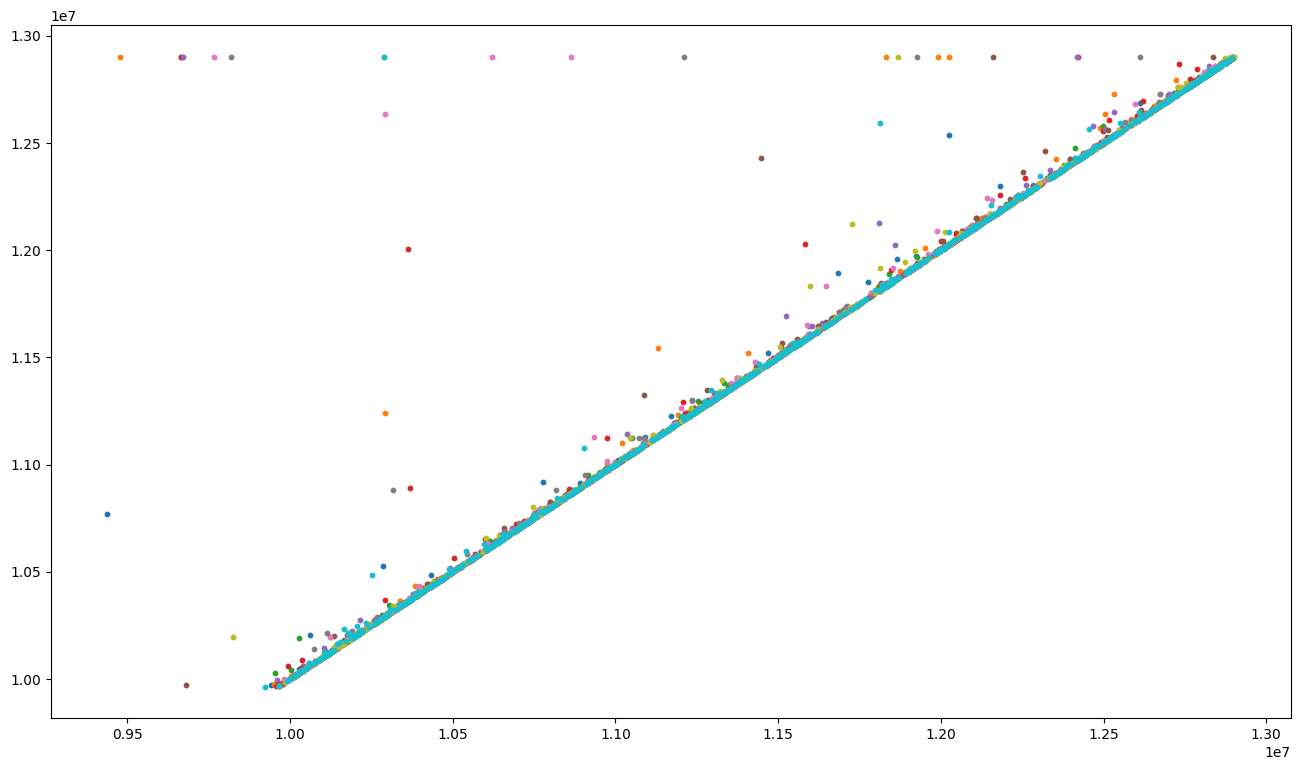

data/fabing_uniform_100_10_1
data/fabing_uniform_100_10_2
data/fabing_uniform_100_10_3
data/fabing_uniform_100_10_4
data/fabing_uniform_100_10_5
data/fabing_uniform_100_10_6
data/fabing_uniform_100_10_7
data/fabing_uniform_100_10_8
data/fabing_uniform_100_10_9
data/fabing_uniform_100_10_10


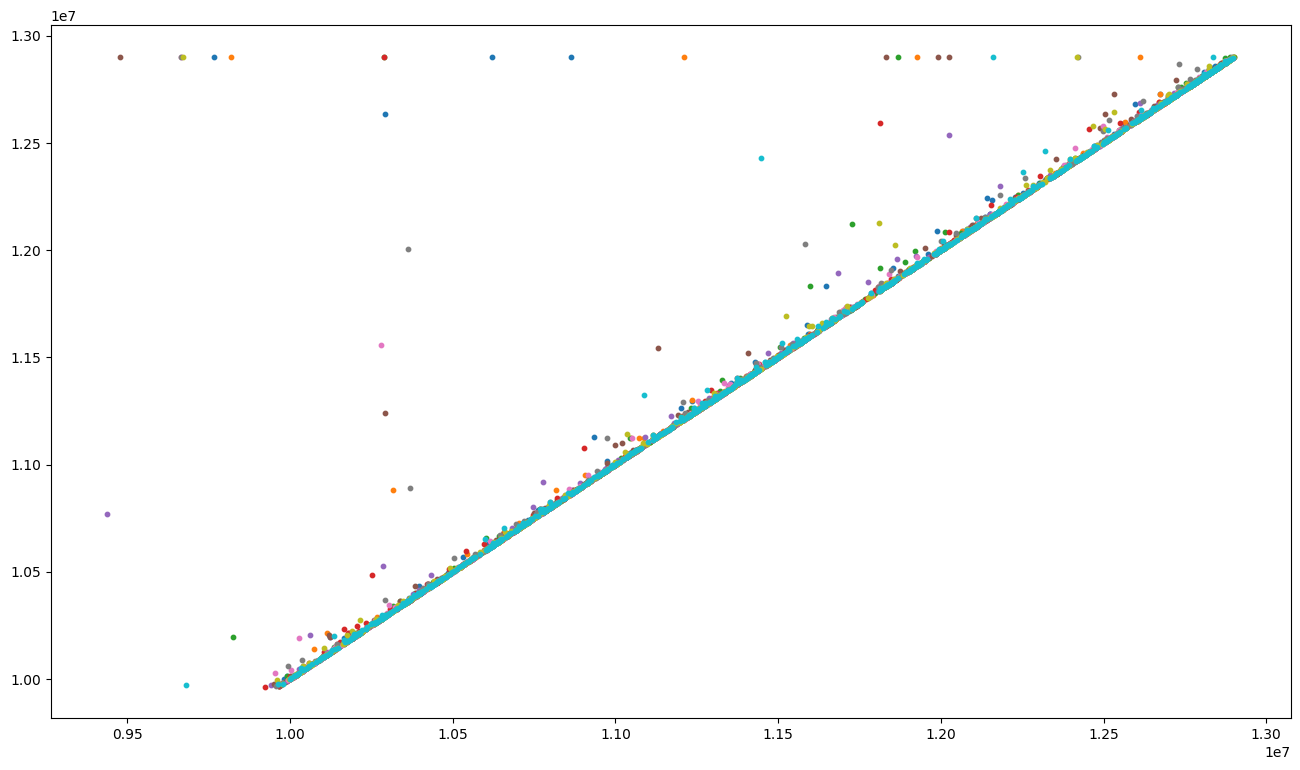

data/fabing_uniform_200_10_1
data/fabing_uniform_200_10_2
data/fabing_uniform_200_10_3
data/fabing_uniform_200_10_4
data/fabing_uniform_200_10_5
data/fabing_uniform_200_10_6
data/fabing_uniform_200_10_7
data/fabing_uniform_200_10_8
data/fabing_uniform_200_10_9
data/fabing_uniform_200_10_10


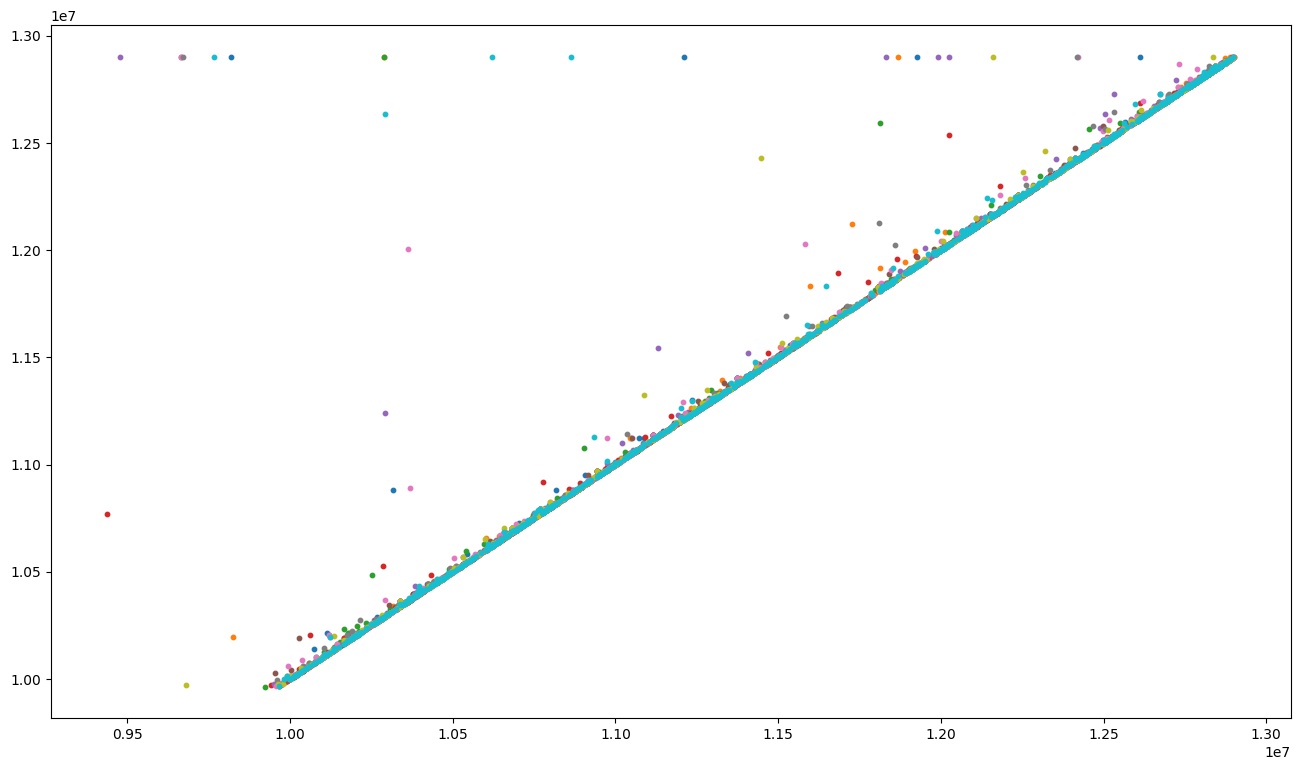

data/fabing_uniform_250_10_1
data/fabing_uniform_250_10_2
data/fabing_uniform_250_10_3
data/fabing_uniform_250_10_4
data/fabing_uniform_250_10_5
data/fabing_uniform_250_10_6
data/fabing_uniform_250_10_7
data/fabing_uniform_250_10_8
data/fabing_uniform_250_10_9
data/fabing_uniform_250_10_10


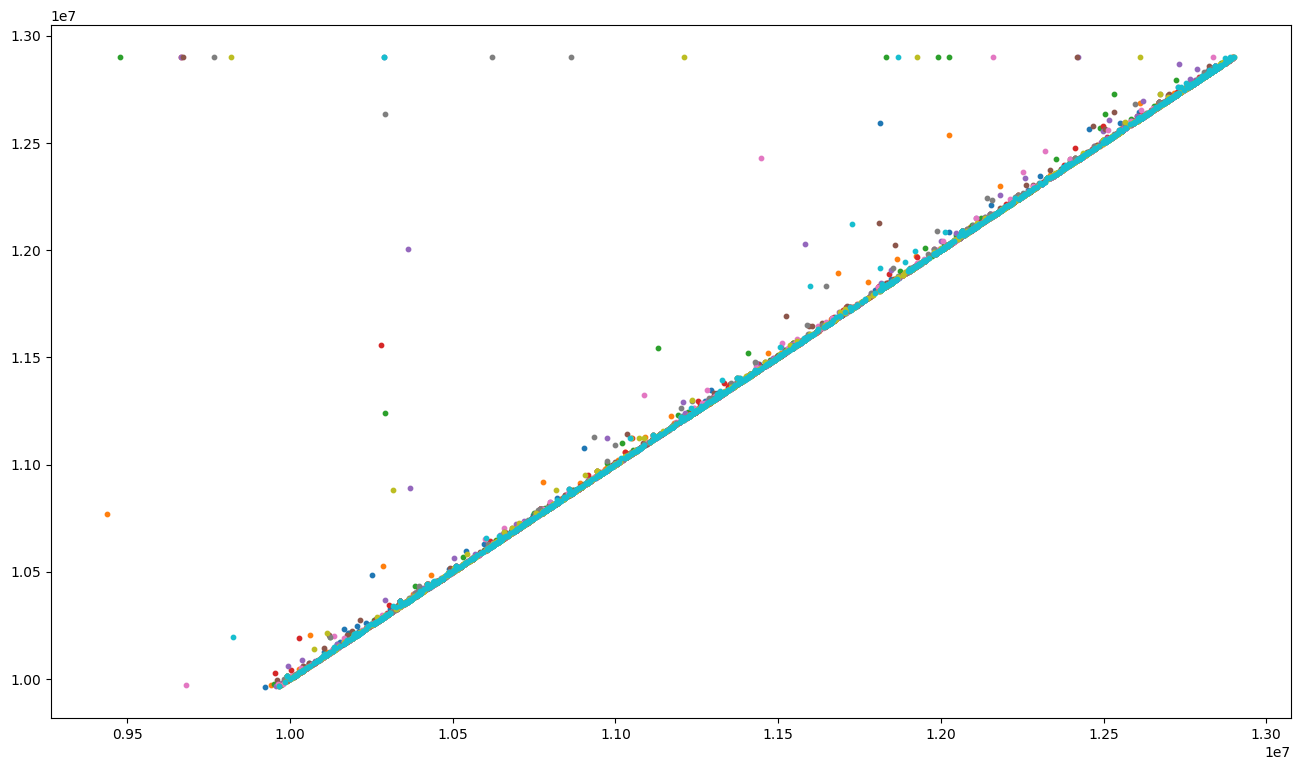

data/fabing_uniform_300_10_1
data/fabing_uniform_300_10_2
data/fabing_uniform_300_10_3
data/fabing_uniform_300_10_4
data/fabing_uniform_300_10_5
data/fabing_uniform_300_10_6
data/fabing_uniform_300_10_7
data/fabing_uniform_300_10_8
data/fabing_uniform_300_10_9
data/fabing_uniform_300_10_10


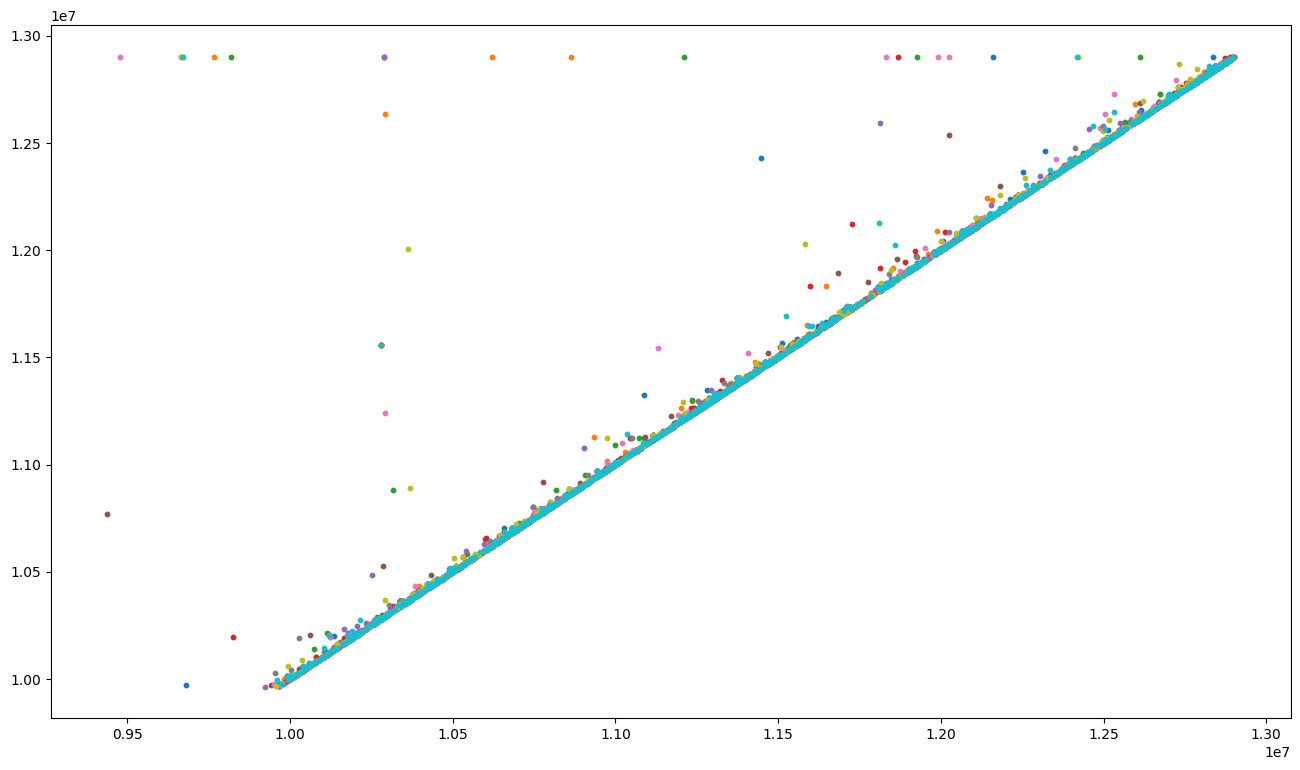

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


nums = ['050', '100', '200', '250', '300']
for num in nums:
    path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu' + num + '.csv'
    df = pd.read_csv(path)
    df['num_gpu'] = 0
    df['gpu_milli'] = 0
    df['gpu_spec'] = ''
    running_df = df
    # # Filter the dataframe
    # # running_df = df[df['pod_phase'] == 'Running']
    # # running_df = running_df[running_df['qos'] == 'LS']
    # # running_df = running_df[running_df['num_gpu'] == 0]
    # # Prepend '16' to 'creation_time' and 'deletion_time'
    # running_df['creation_time'] = running_df['creation_time'].apply(lambda x: '16' + str(x))
    # running_df['deletion_time'] = running_df['deletion_time'].apply(lambda x: '16' + str(x))
    # # running_df['scheduled_time'] = running_df['scheduled_time'].apply(lambda x: '16' + str(x))
    # # Convert 'creation_time' and 'deletion_time' to datetime
    # running_df['creation_time'] = pd.to_datetime(running_df['creation_time'], unit='s')
    # running_df['deletion_time'] = pd.to_datetime(running_df['deletion_time'], unit='s')
    # # running_df['scheduled_time'] = pd.to_datetime(running_df['scheduled_time'], unit='s')

    # # Convert datetime to RFC3339 format
    # running_df['creation_time'] = running_df['creation_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    # running_df['deletion_time'] = running_df['deletion_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    # running_df['scheduled_time'] = running_df['scheduled_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    tenants = [1, 2, 3, 5, 10, 15, 20]
    tenants = [10]
    plt.figure(figsize=(16, 9))
    for tenant in tenants:
        # Split the dataframe into parts
        dfs = [df.iloc[i::tenant].reset_index(drop=True) for i in range(tenant)]
        # Save each part to a separate CSV file
        for i, df_part in enumerate(dfs, 1):
            out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/fabing_uniform_{}_{}_{}.csv'.format(num, tenant, i)
            print('data/fabing_uniform_{}_{}_{}'.format(num, tenant, i))
            df_part = df_part[df_part['creation_time'] > 9e6]
            plt.scatter(x=df_part['creation_time'], y=df_part['deletion_time'], s=10)
            # df_part.to_csv(out_file.format(i), index=False)
            # print(df_part.head(2))
    plt.show()


Add the price to the node list

In [ ]:
import pandas as pd

# Load the dataframe from the CSV file
path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_node_list_all_node.csv'
node_df = pd.read_csv(path)

# Load the price dataframe from the CSV file
path = '/home/fabing/projects/kubernetes-scheduler-simulator/node_list_price.csv'
price_df = pd.read_csv(path)
# Remove commas and convert to float
price_df['Aliyun cost (yuan/month)'] = price_df['Aliyun cost (yuan/month)'].replace(',', '', regex=True).astype(float)

result_df = pd.merge(node_df, price_df, on=['cpu_milli', 'memory_mib'], how='left')
result_df.to_csv('/home/fabing/projects/kubernetes-scheduler-simulator/node_list_all_node_price.csv', index=False)

In [ ]:
import pandas as pd

path = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/2023_cpu/fabing_cpu_050_1_1/05-BestFit/1.3/42/analysis_price.csv'
price_path = '/home/fabing/projects/kubernetes-scheduler-simulator/node_list_all_node_price.csv'

price_df = pd.read_csv(price_path)
total_cost = 0
with open(path, 'r') as f:
    line = f.readline()
    line = line.replace(r'\n', '')
    line = line.split(r',')
    for sn in line:
        sn = sn.strip()
        try:
            aliyun_cost = price_df.loc[price_df['sn'] == sn, 'Aliyun cost (yuan/month)']
            total_cost += aliyun_cost.values[0]
        except IndexError:
            print(f"No match found for sn: {sn}")
    print(total_cost)

# Draw usages: Merge the node list and the table, and calulate the price

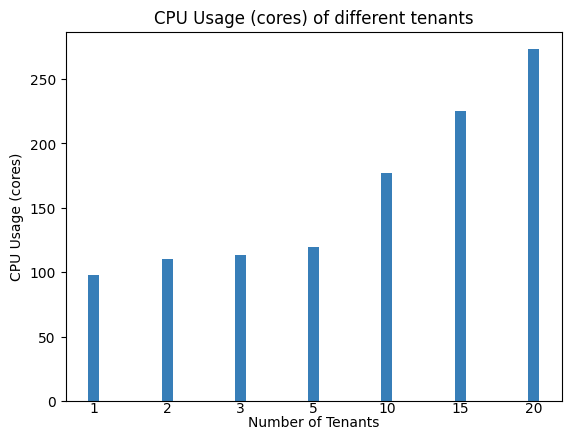

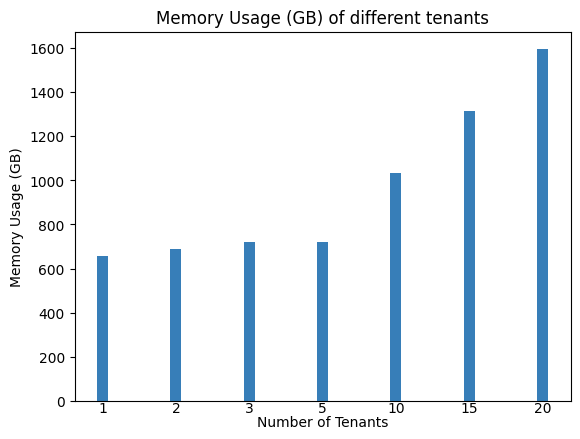

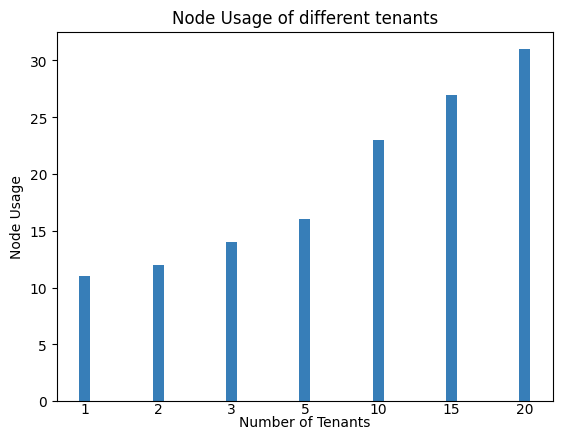

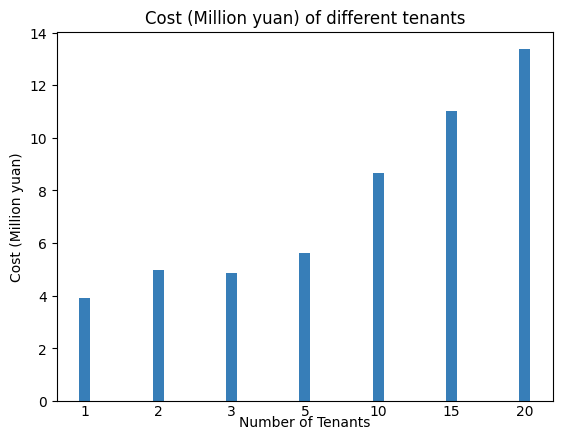

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def draw(name):
    # Create a new figure for 'cpu'
    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure()
    # Loop over unique traces
    for idx, i in enumerate(sorted_df['traces'].unique()):
        # Filter the dataframe
        filtered_df = sorted_df[sorted_df['traces'] == i]
        # Sort by 'tenants'
        filtered_df = filtered_df.sort_values('tenants')
        x_labels = [str(i) for i in filtered_df['tenants']]
        x_pos = np.array([i for i, _ in enumerate(x_labels)])
        # Draw a bar chart for 'cpu' with offset
        plt.bar(x_pos + idx * bar_width, filtered_df[name], width=bar_width, color=colors[idx % len(colors)], label=f'trace={i}')
        # Add scatter plot and line
        # plt.scatter(filtered_df['tenants'] + idx * bar_width, filtered_df['cpu'], color=colors[idx % len(colors)])
    # Set xticks
    # plt.xticks(sorted_df['tenants'].unique())
    plt.xticks([])
    for i in range(len(x_labels)):
        plt.text(x_pos[i] + idx * bar_width/2, -0.1, x_labels[i], ha='center', va='top')
    plt.xlabel('Number of Tenants', labelpad=10)
    plt.ylabel(ylabels[name])
    # Add a legend
    # plt.legend(loc='upper left')
    plt.title(f'{ylabels[name]} of different tenants')
    # Show the plot
    plt.show()


# Load the dataframe from the CSV file
path = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_price_discrete.csv'
out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/cpu_analysis_price_discrete_sum.csv'
df = pd.read_csv(path)
# Extract the prefix of the 'workload' column
df['workload_prefix'] = df['workload'].str.rsplit('_', n=1).str[0]

# Calculate the average 'use_nodes' for each 'workload_prefix'
df = df.groupby('workload_prefix').sum()
df.drop(columns=['workload', 'sc_policy', 'tune'], inplace=True)
df.to_csv(out_file)
df = pd.read_csv(out_file)
# Split the 'workload_prefix' into four parts
df[['prefix', 'type', 'traces', 'tenants']] = df['workload_prefix'].str.split('_', expand=True)
# Convert the 'traces' and 'tenants' columns to numeric types
df[['traces', 'tenants']] = df[['traces', 'tenants']].apply(pd.to_numeric)
# df['cpu'] = df['cpu'].astype(float)
# df['mem'] = df['mem'].astype(float)
df['cpu'] = df['cpu'] / 1000
df['mem'] = df['mem'] / 1024
df['cost'] = df['cost'] / 1000000
# Group by 'first_number' and calculate the mean of 'use_nodes'
# grouped_df = df.groupby('first_number')['cost'].mean()

# Sort by 'second_number'
sorted_df = df.sort_values('traces')
# Define color list
colors = ['#377eb8', '#4daf4a', '#e41a1c', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

# Define bar width
bar_width = 0.15

# Filter the dataframe
# filtered_df = sorted_df[sorted_df['traces'] == i]
# # Sort by 'tenants'
# filtered_df = filtered_df.sort_values('tenants')
# x_labels = [str(i) for i in filtered_df['tenants']]
# x_pos = np.array([i for i, _ in enumerate(x_labels)])
ylabels = {'cpu': 'CPU Usage (cores)', 'mem': 'Memory Usage (GB)', 'used_nodes': 'Node Usage', 'cost': 'Cost (Million yuan)'}
draw('cpu')
draw('mem')
draw('used_nodes')
draw('cost')

# save to a new CSV file
sorted_df.to_csv(out_file)

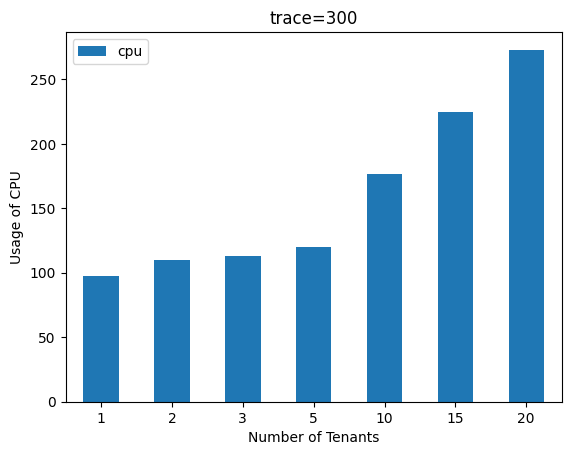

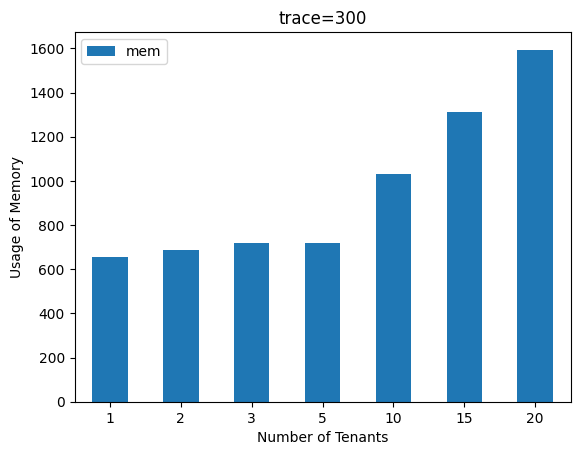

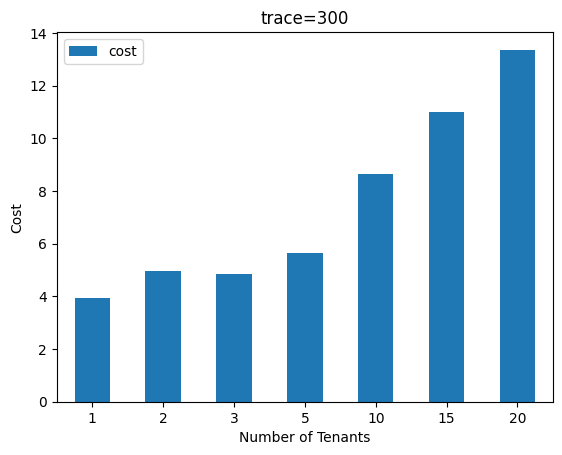

In [16]:
# Draw bar charts
for i in sorted_df['traces'].unique():
    # Filter the dataframe
    filtered_df = sorted_df[sorted_df['traces'] == i]
    # Sort by 'second_number'
    filtered_df = filtered_df.sort_values('tenants')
    # Draw a bar chart for 'cpu'
    ax = filtered_df.plot.bar(x='tenants', y='cpu', rot=0, title=f'trace={i}', xlabel='Number of Tenants', ylabel='Usage of CPU')
    ax.legend(loc='upper left')
    plt.show()
    # Draw a bar chart for 'mem'
    ax = filtered_df.plot.bar(x='tenants', y='mem', rot=0, title=f'trace={i}', xlabel='Number of Tenants', ylabel='Usage of Memory')
    ax.legend(loc='upper left')
    plt.show()
    # Draw a bar chart for 'cost'
    ax = filtered_df.plot.bar(x='tenants', y='cost', rot=0, title=f'trace={i}', xlabel='Number of Tenants', ylabel='Cost')
    ax.legend(loc='upper left')
    plt.show()

## draw timeline
x: timeline
y: the index of the pod

first, sort by the creation time
second, draw the timeline

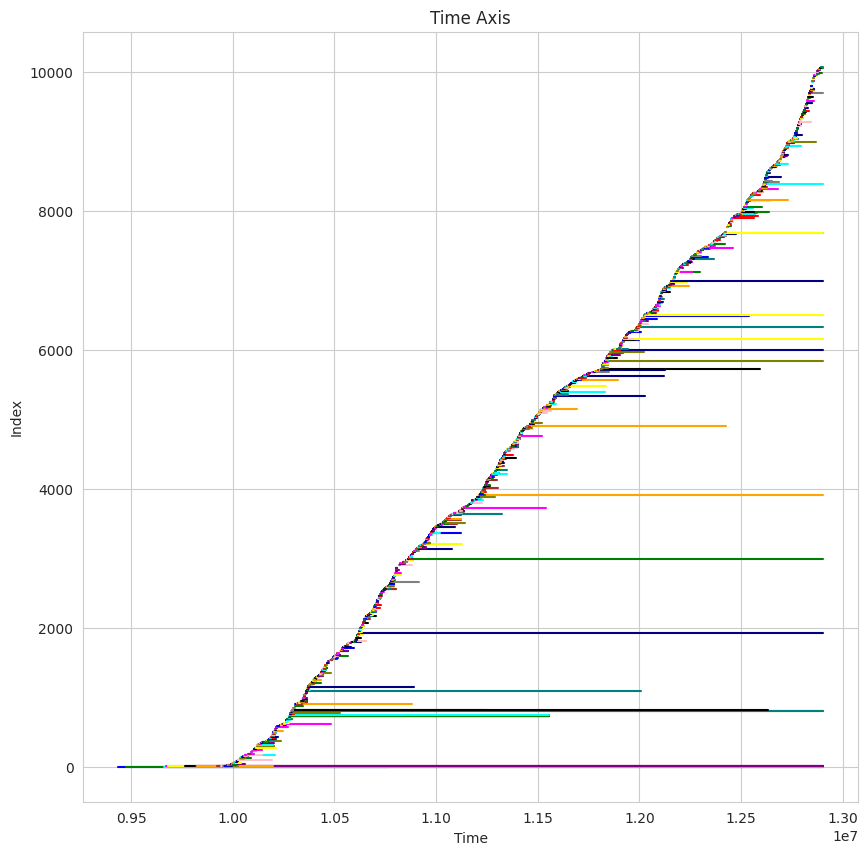

In [26]:
import pandas as pd
import matplotlib.pyplot as plt 

path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu300.csv'
df = pd.read_csv(path)

df = df[df['creation_time'] >= 9000000]
df = df.sort_values("creation_time", ascending=True)

plt.figure(figsize=(10, 10))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'teal', 'navy']
idx = 0

for index, row in df.iterrows():
    creation_time = row['creation_time']
    deletion_time = row['deletion_time']

    color = colors[idx % 15]
    idx += 1
    
    plt.plot([creation_time, deletion_time], [idx, idx], color=color)

plt.title("Time Axis")
plt.xlabel("Time")
plt.ylabel("Index")

plt.show()




Resource usage of each tenant

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


traces = ['050', '100', '200', '250', '300']
workload_df = pd.DataFrame(columns=['traces', 'cpu_time', 'mem_time', 'duration'])
for i, trace in enumerate(traces):
    path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu{}.csv'.format(trace)
    data = pd.read_csv(path)
    data.loc[data['creation_time'] < 8387257, 'creation_time'] = 8387257
    time_diff = (data['deletion_time'] - data['creation_time'])
    data['cpu_time'] = time_diff * data['cpu_milli']
    data['mem_time'] = time_diff * data['memory_mib']
    # print sum of column cpu_milli and memory_mib
    # print(f'workload for {trace}, {data["cpu_milli"].sum()}, {data["memory_mib"].sum()}')
    workload_df.loc[i] = [trace, data["cpu_time"].sum()/1000, data["mem_time"].sum()/1024, data['deletion_time'].max() - data['creation_time'].min()]
workload_df[['traces']] = workload_df[['traces']].apply(pd.to_numeric)    
# Load the dataframe from the CSV file
path = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results_large/analysis_price_discrete.csv'
out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results_large/uniform_analysis_price_discrete_sum.csv'
df = pd.read_csv(path)
# Extract the prefix of the 'workload' column
df['workload_prefix'] = df['workload'].str.rsplit('_', n=1).str[0]

# Calculate the average 'use_nodes' for each 'workload_prefix'
df = df.groupby('workload_prefix').sum()
df.drop(columns=['workload', 'sc_policy', 'tune'], inplace=True)
df.to_csv(out_file)
df = pd.read_csv(out_file)
# Split the 'workload_prefix' into four parts
df[['prefix', 'type', 'traces', 'tenants']] = df['workload_prefix'].str.split('_', expand=True)
# Convert the 'traces' and 'tenants' columns to numeric types
df[['traces', 'tenants']] = df[['traces', 'tenants']].apply(pd.to_numeric)

# Create empty lists to store the results
cpu_utilization = []
mem_utilization = []
cpu_times = []
mem_times = []
durations = []

# Traverse df['traces']
for tenant in df['tenants']:
    trace = df.loc[df['tenants'] == tenant, 'traces'].values[0]
    # Fetch the row from workload_df where workload_df['traces'] == trace
    row = workload_df[workload_df['traces'] == trace]
    
    # Get the cpu_milli and memory_mib values from the fetched row
    cpu_time = row['cpu_time'].values[0]
    mem_time = row['mem_time'].values[0]
    duration = row['duration'].values[0]
    
    cluster_cpu = df.loc[df['tenants'] == tenant, 'cpu']
    cluster_mem = df.loc[df['tenants'] == tenant, 'mem']
    # Calculate cpu_utilization and mem_utilization
    cpu_util = cpu_time / cluster_cpu / duration
    mem_util = mem_time / cluster_mem / duration
    
    # Append the results to the lists
    cpu_utilization.append(cpu_util.values[0])
    mem_utilization.append(mem_util.values[0])
    cpu_times.append(cpu_time)
    mem_times.append(mem_time)
    durations.append(duration)
    print(tenant, cpu_util, mem_util)

# Add cpu_utilization and mem_utilization columns to df
df['cpu_utilization'] = cpu_utilization
df['mem_utilization'] = mem_utilization
df['cpu_times'] = cpu_times
df['mem_times'] = mem_times
df['durations'] = durations
# Print the updated df
# print(df)

# df['cpu_utilization'] = df['traces'].apply(lambda x: workload_df.loc[workload_df['traces'] == x, 'cpu_time'].values[0])
# df['mem_utilization'] = df['traces'].apply(lambda x: workload_df.loc[workload_df['traces'] == x, 'mem_time'].values[0])

# Sort by 'second_number'
sorted_df = df.sort_values('traces')
sorted_df.to_csv(out_file)
print('save to {}'.format(out_file))


1 0    0.005671
Name: cpu, dtype: float64 0    0.002272
Name: mem, dtype: float64
10 1    0.003141
Name: cpu, dtype: float64 1    0.001446
Name: mem, dtype: float64
15 2    0.002468
Name: cpu, dtype: float64 2    0.001136
Name: mem, dtype: float64
2 3    0.005036
Name: cpu, dtype: float64 3    0.002169
Name: mem, dtype: float64
20 4    0.002033
Name: cpu, dtype: float64 4    0.000936
Name: mem, dtype: float64
3 5    0.004913
Name: cpu, dtype: float64 5    0.002075
Name: mem, dtype: float64
5 6    0.004634
Name: cpu, dtype: float64 6    0.002075
Name: mem, dtype: float64
save to /home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results_large/uniform_analysis_price_discrete_sum.csv


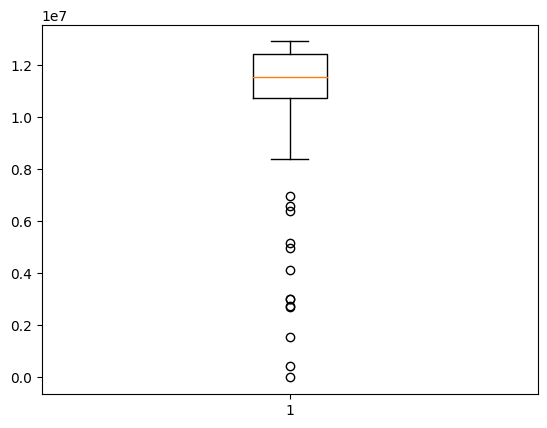

8387257


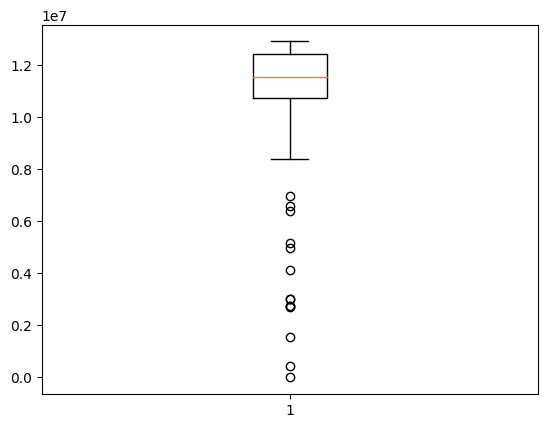

8387257


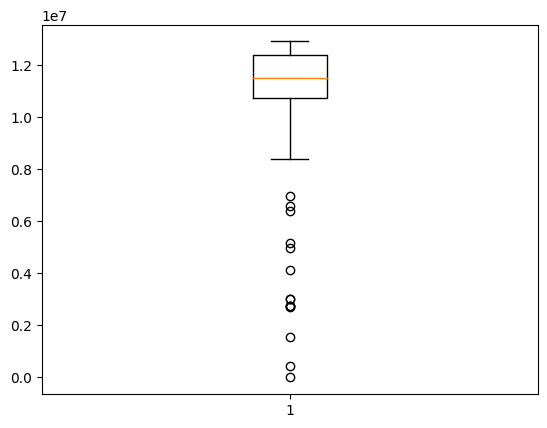

8387257


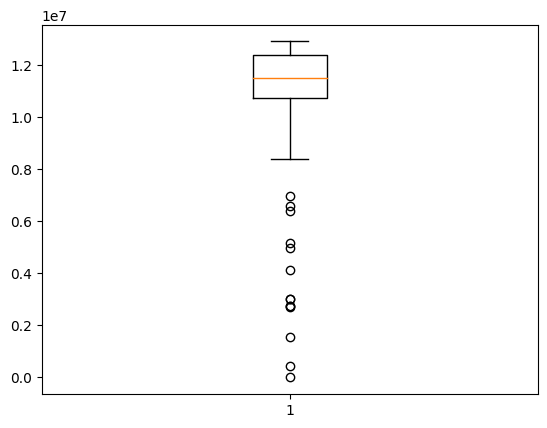

8387257


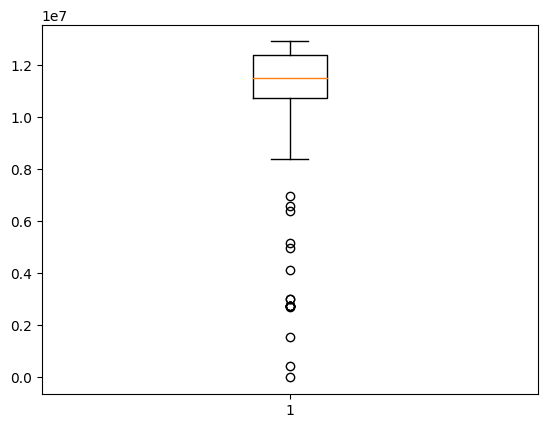

8387257


In [42]:
import pandas as pd
import numpy as np
traces = ['050', '100', '200', '250', '300']
workload_df = pd.DataFrame(columns=['traces', 'cpu_milli', 'memory_mib'])
for i, trace in enumerate(traces):
    path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu{}.csv'.format(trace)
    data = pd.read_csv(path)
    plt.boxplot(data['creation_time'])
    plt.show()
    data = data['creation_time']
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # 计算异常值的判定标准（通常是1.5 * IQR）
    outlier_step = 1.5 * IQR

    outliers = data[(data > Q1 - outlier_step) & (data < Q3 + outlier_step)]
    print(outliers.min())
    # # 计算数据列的均值和标准差
    # mean = data['deletion_time'].mean()
    # std = data['deletion_time'].std()
    # # 计算标准化分数（Z-Score）
    # data['z_score'] = (data['deletion_time'] - mean) / std

    # # 设置阈值，例如3
    # threshold = 3

    # # 根据阈值筛选离群点
    # outliers = data[data['z_score'].abs() > threshold]

    # # 输出离群点
    # print(outliers)






## stress line

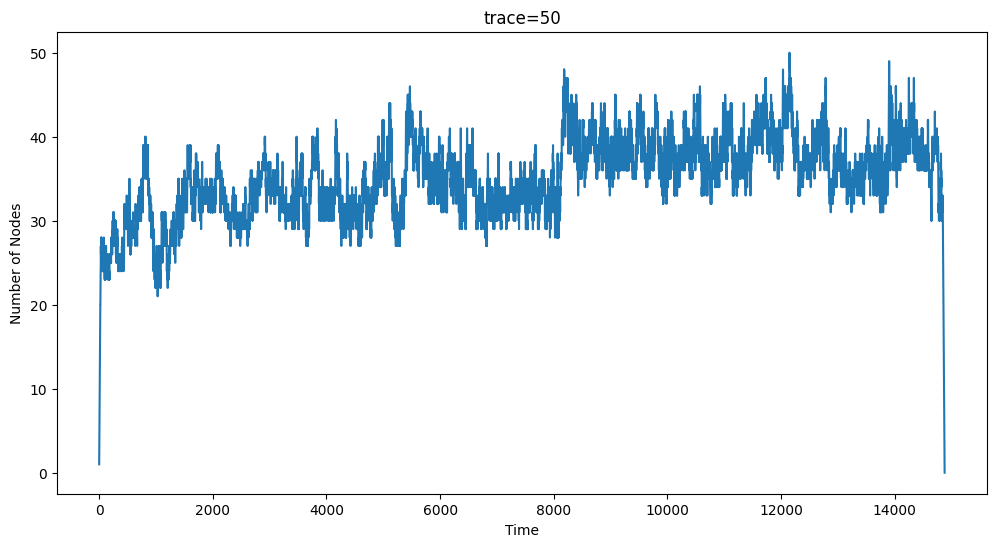

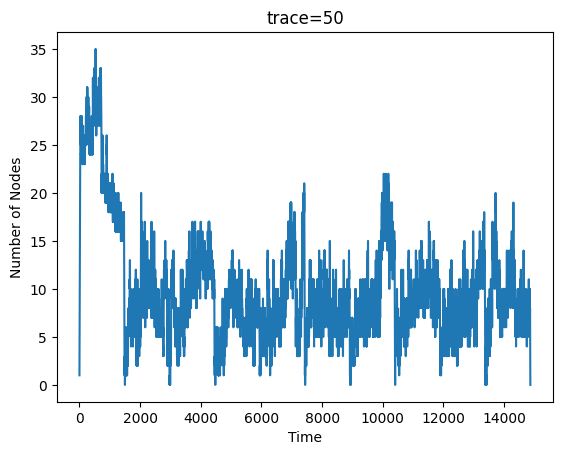

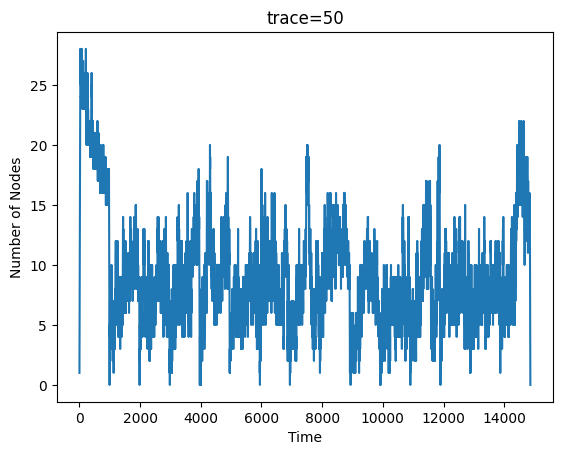

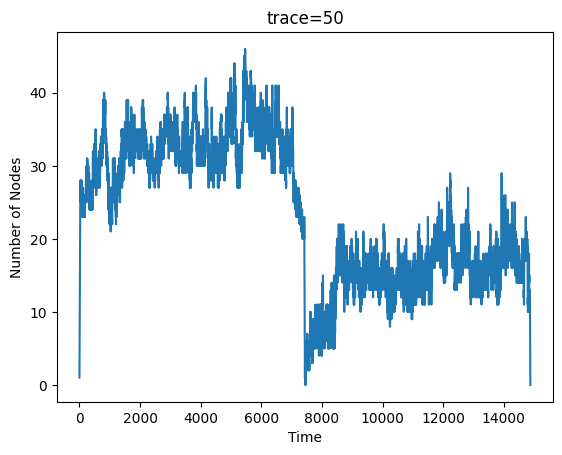

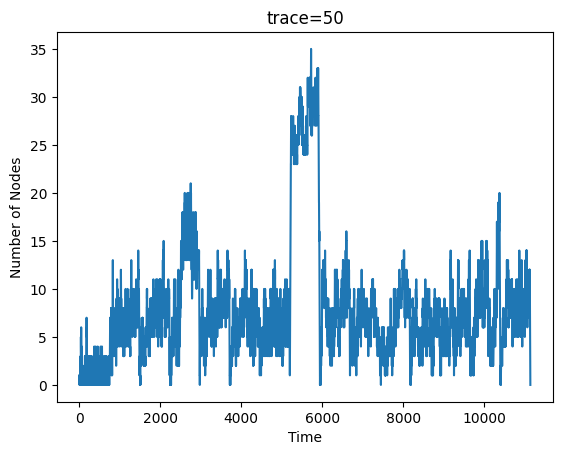

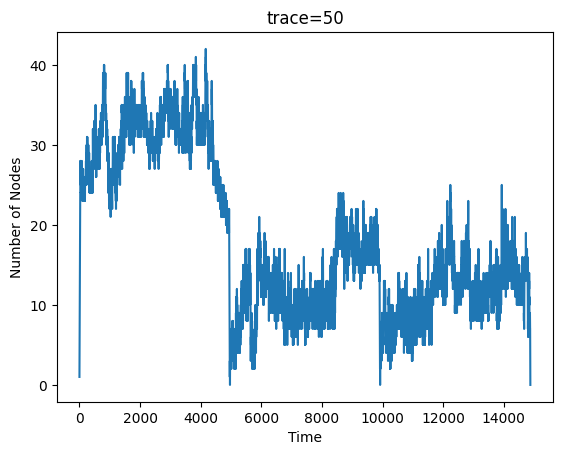

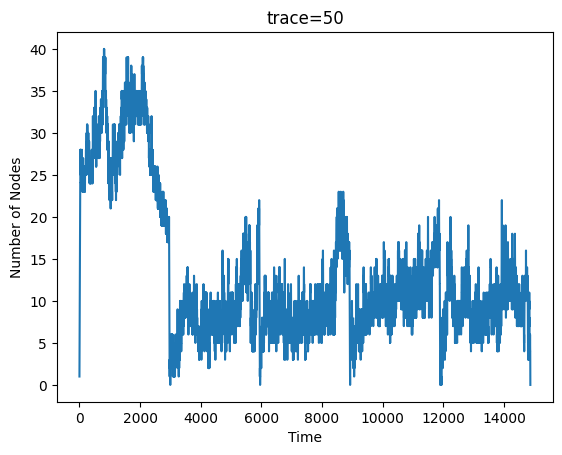

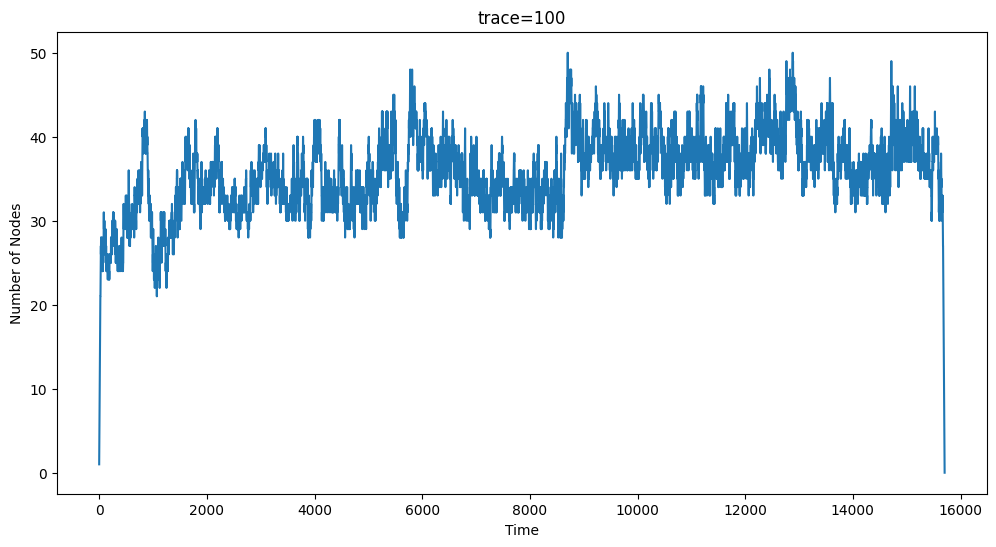

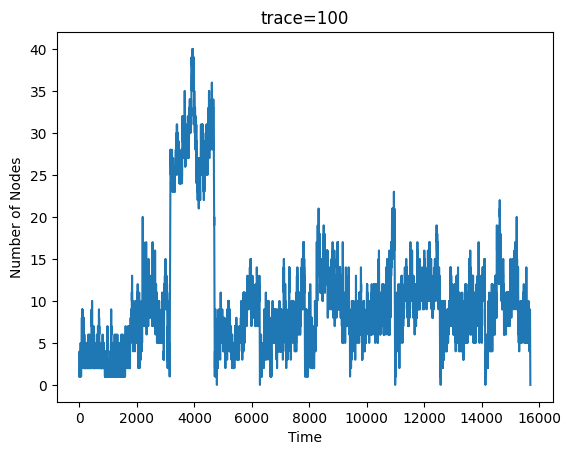

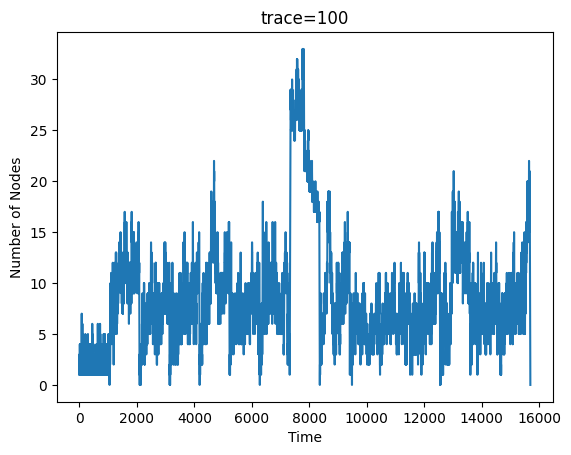

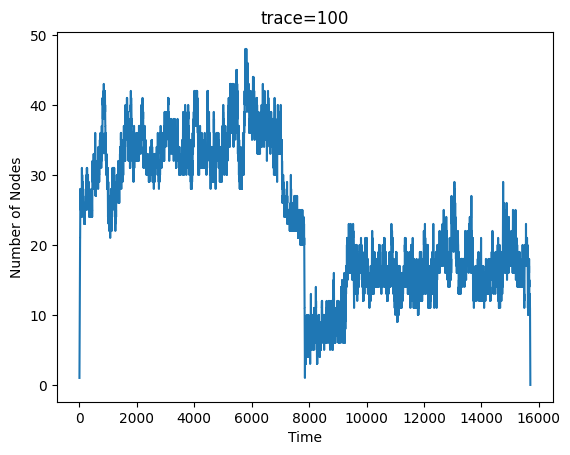

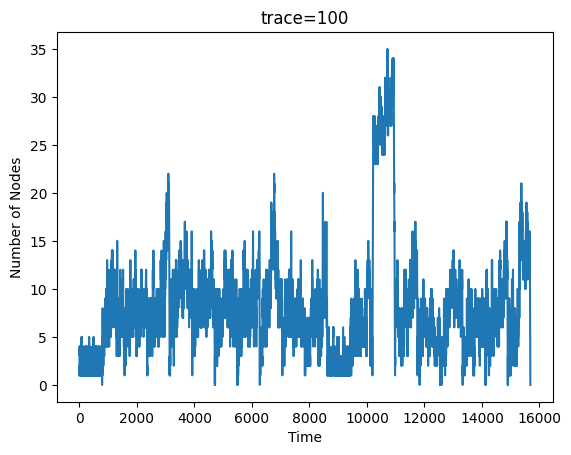

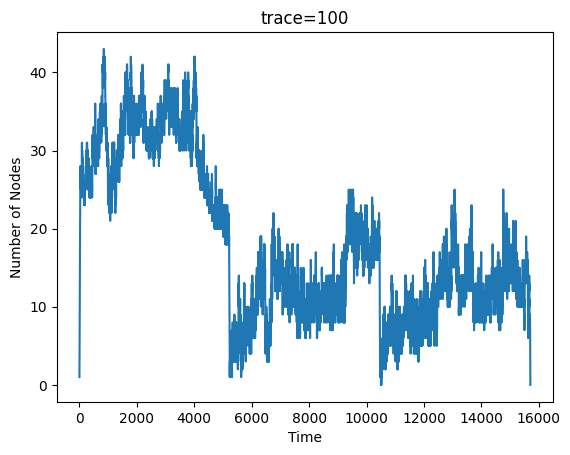

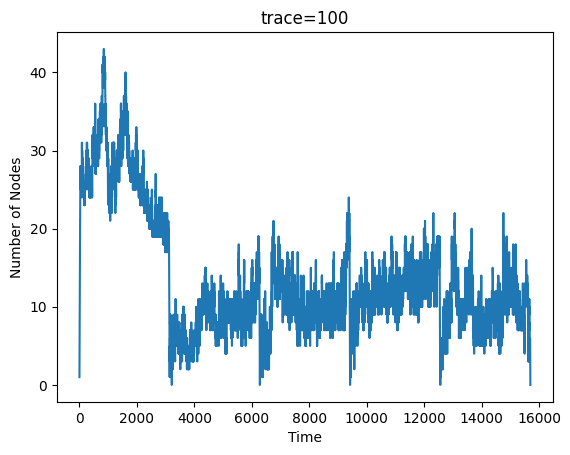

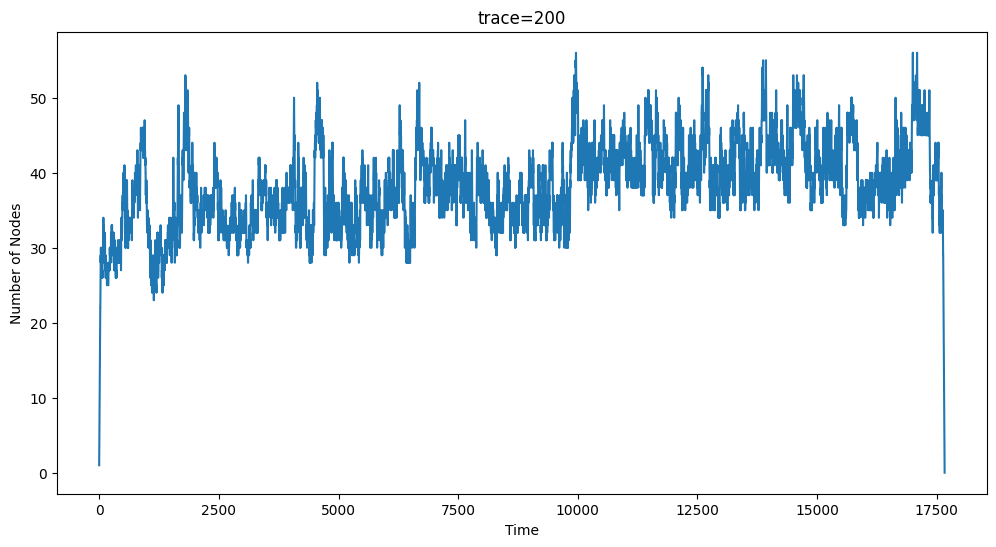

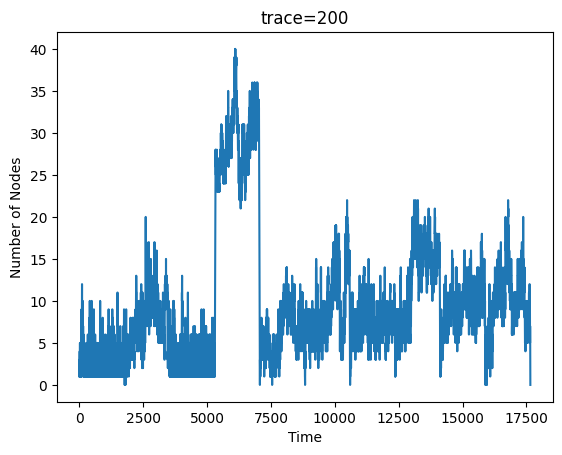

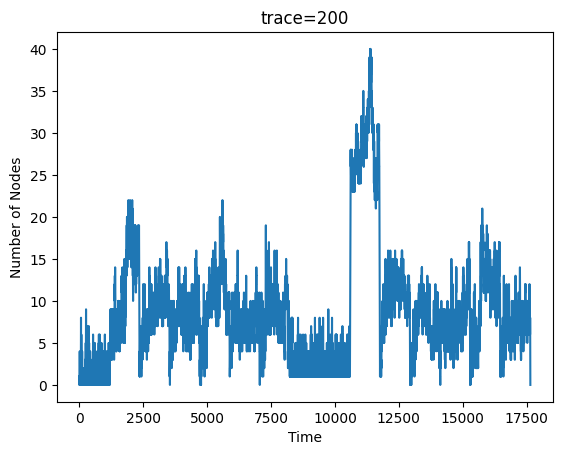

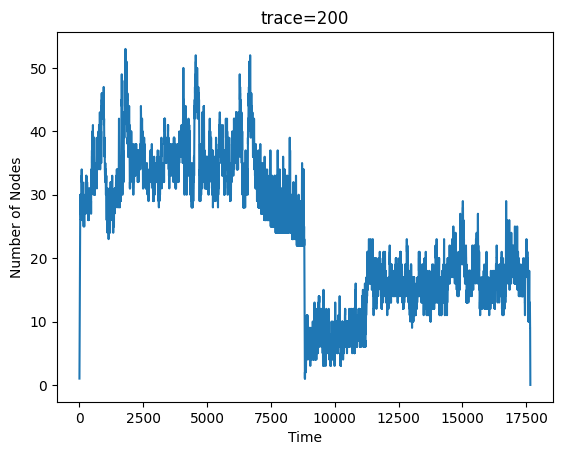

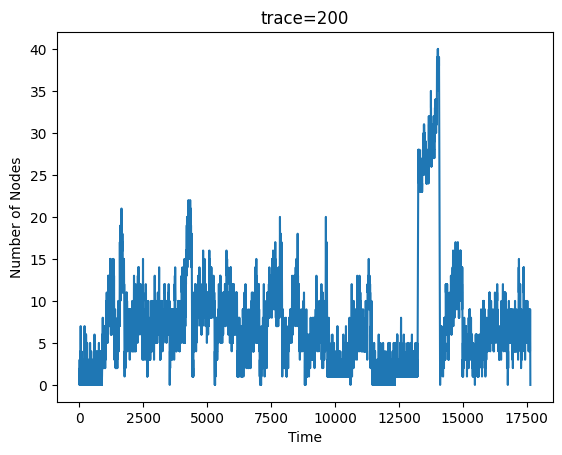

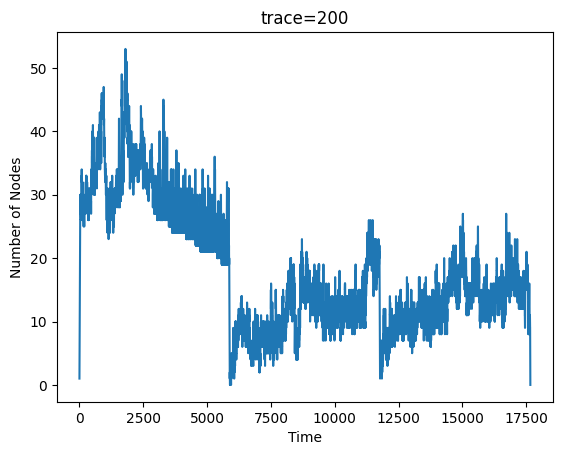

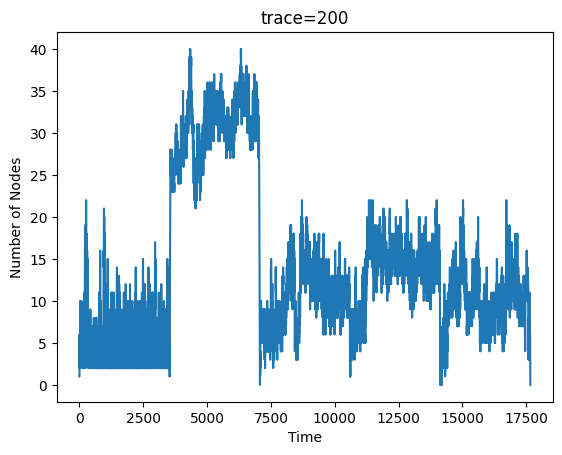

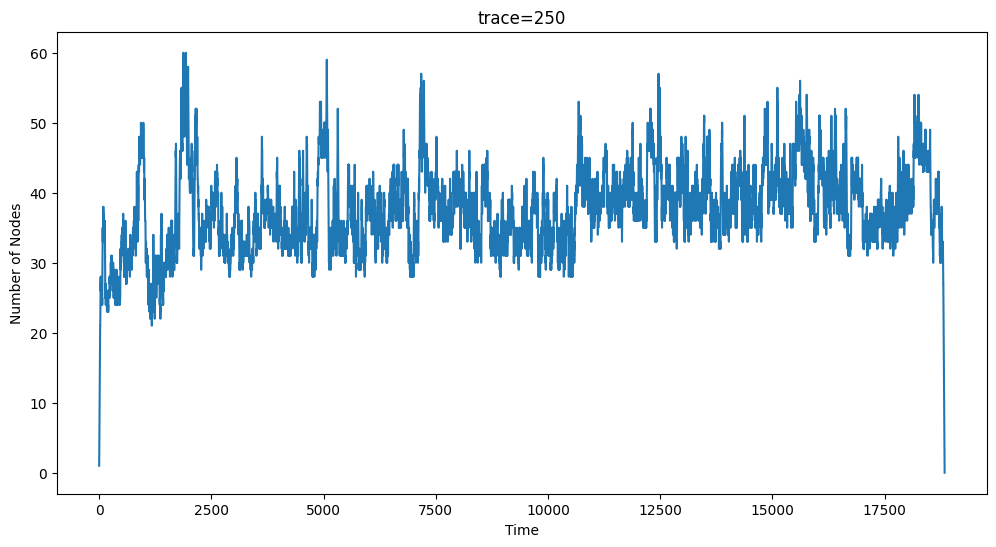

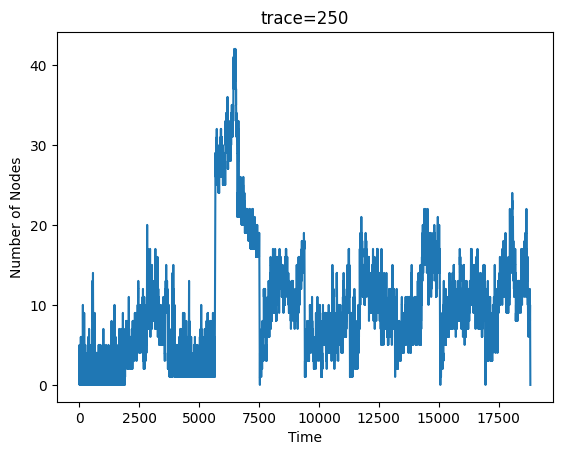

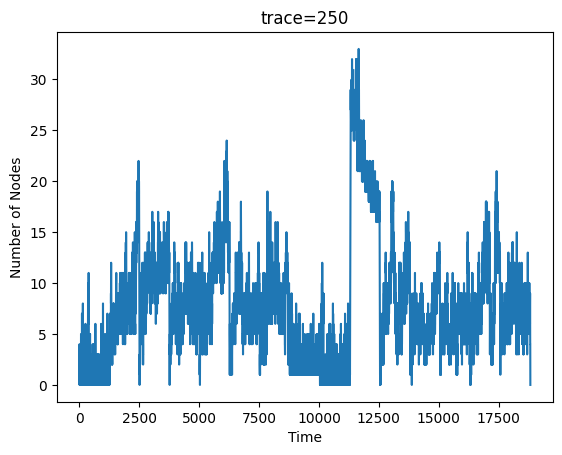

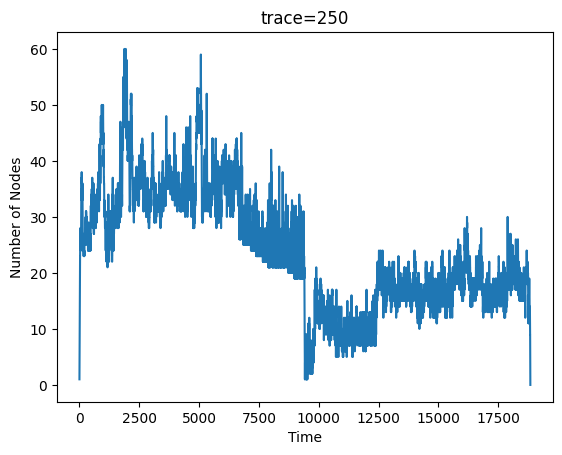

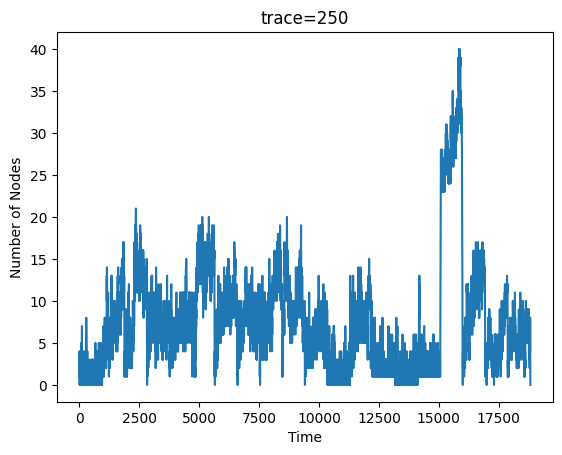

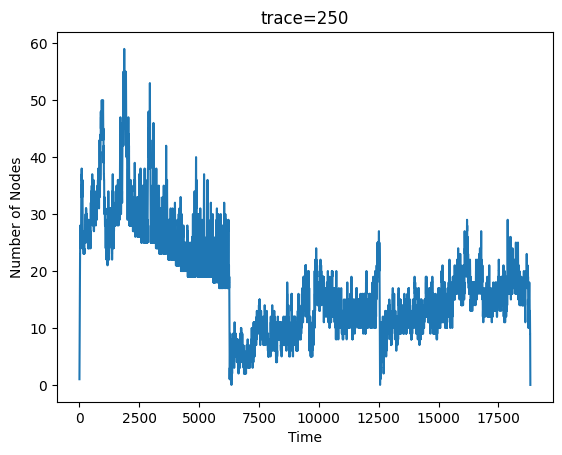

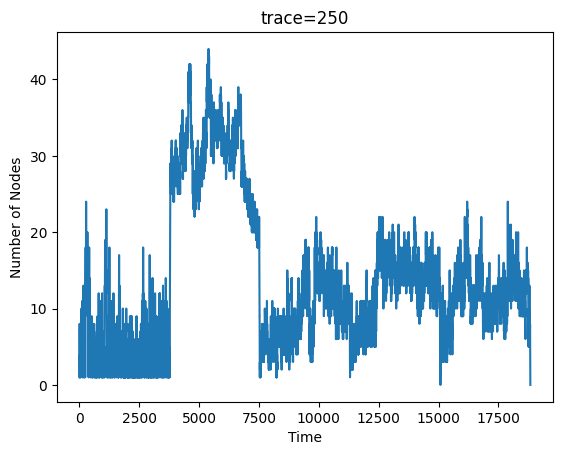

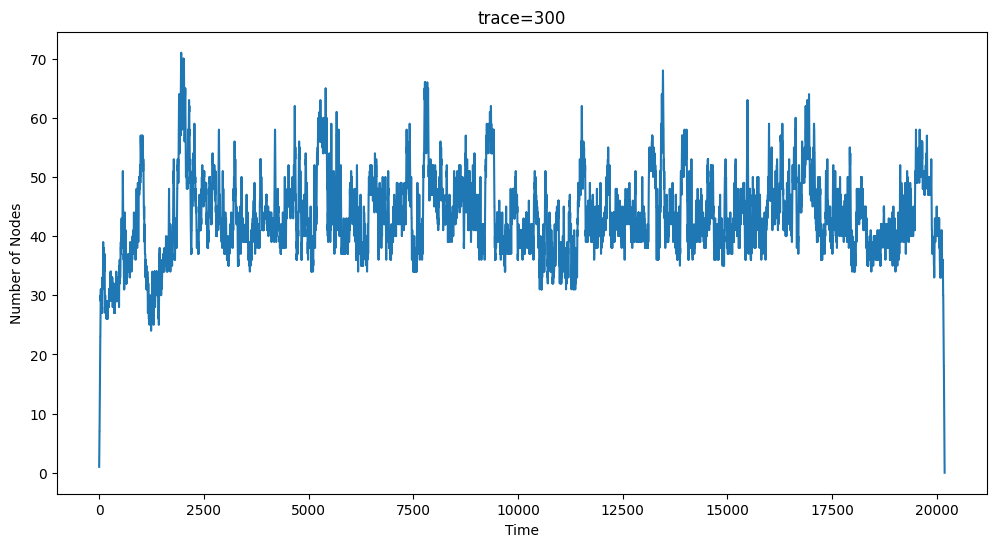

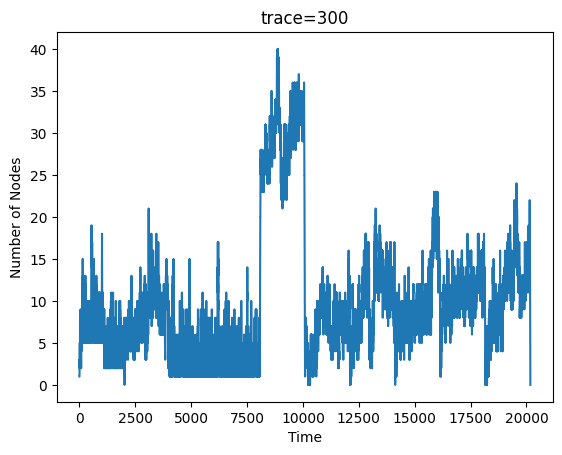

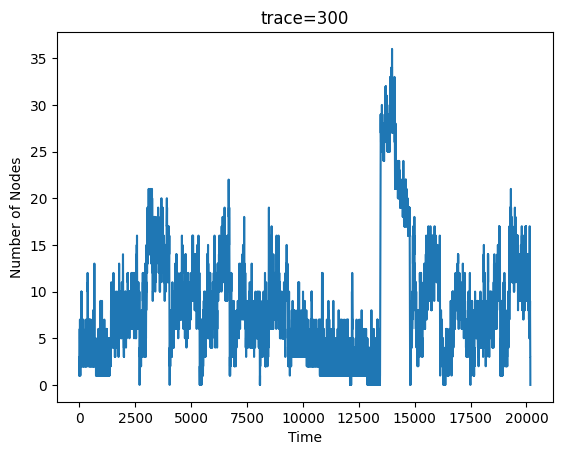

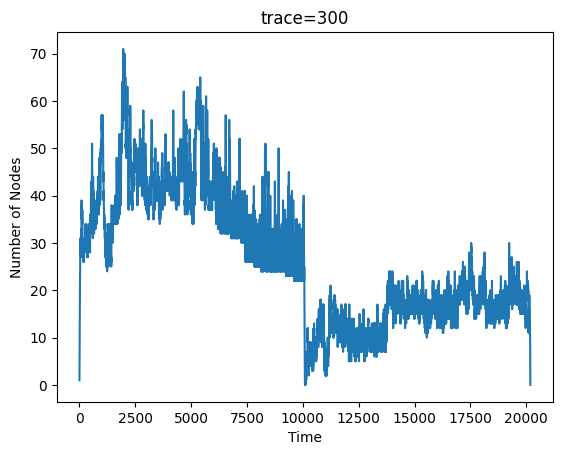

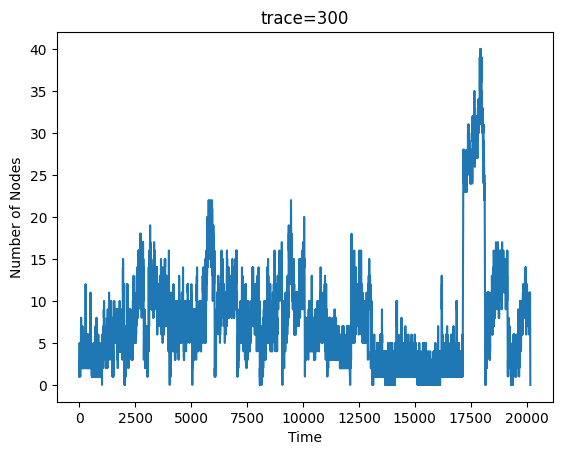

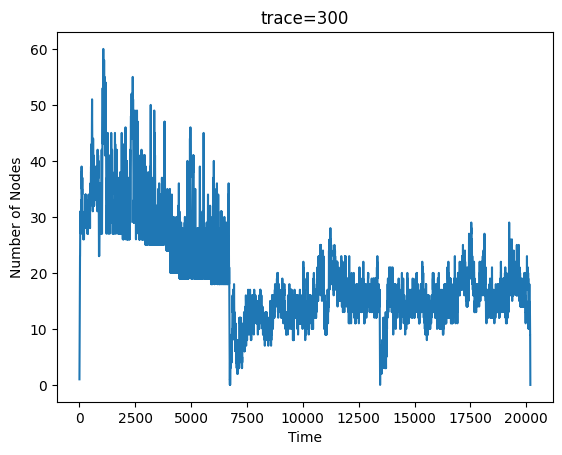

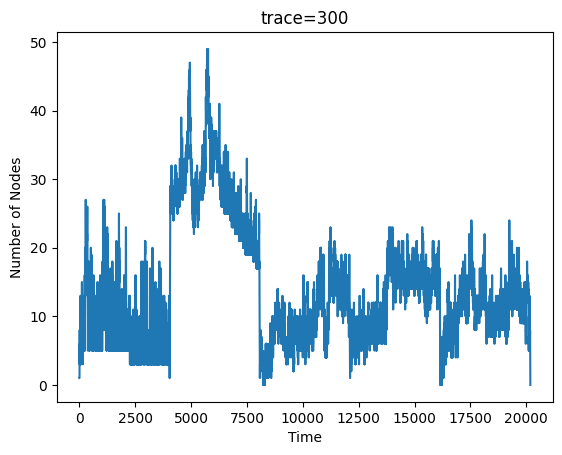

In [ ]:
import ast
import pandas as pd
import matplotlib.pyplot as plt

def convert_str_2_list(data):
    data = data.replace('[', '')
    data = data.replace(']', '')
    return [int(x) for x in data.split(',')]
    
# Load the dataframe from the CSV file
path = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_usage_discrete.csv'
out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_usage_discrete_sum.csv'
df = pd.read_csv(path)
# merge
df['workload_prefix'] = df['workload'].str.rsplit('_', n=1).str[0]

# Calculate the average 'use_nodes' for each 'workload_prefix'
df = df.groupby('workload_prefix').sum()
df.drop(columns=['workload', 'sc_policy', 'tune'], inplace=True)

df.to_csv(out_file)
df = pd.read_csv(out_file)
# Split the 'workload_prefix' into four parts
df[['prefix', 'type', 'traces', 'tenants']] = df['workload_prefix'].str.split('_', expand=True)
# Convert the 'traces' and 'tenants' columns to numeric types
df[['traces', 'tenants']] = df[['traces', 'tenants']].apply(pd.to_numeric)

for i in df['traces'].unique():
    filtered_df = df[df['traces'] == i]
    plt.figure(figsize=(12, 6))  # Change the numbers to fit your needs
    for j in filtered_df['tenants'].unique():
        filtered_df2 = filtered_df[filtered_df['tenants'] == j]
        # print(filtered_df2['node_list'].iloc[0])
        values = convert_str_2_list(filtered_df2['node_list'].iloc[0])
        plt.plot(values)
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        # plt.legend()
        plt.title(f'trace={i}')
        plt.show()


# Utilization of each tenant

In [1]:
import pandas as pd

traces = ['050', '100', '200', '250', '300']
for trace in traces:
    path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu{}.csv'.format(trace)
    data = pd.read_csv(path)
    # Delete rows where 'creation_time' is smaller than 10000000
    # data = data[data['creation_time'] >= 8000000]
    # add a column: (deletion_time - creation_time)*cpu_milli
    time_diff = (data['deletin_time'] - data['creation_time'])
    data['cpu_time'] = time_diff * data['cpu_milli']
    data['mem_time'] = time_diff * data['memory_mib']
    # print sum of column cpu_milli and memory_mib
    print(time_diff.sum())
    print(f'workload for {trace}, {data["cpu_time"].sum()}, {data["mem_time"].sum()}')

price_path = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_price_discrete.csv'
price_df = pd.read_csv(price_path)
for trace in traces:
    tenants = [1, 2, 3, 5, 10, 15, 20]
    for tenant in tenants:
        for i in range(1, tenant+1):
            # load node usage of each tenant 
            workload = f'fabing_cpu_{trace}_{tenant}_{i}'
            cpu = price_df.loc[price_df['workload'] == workload, 'cpu']
            mem = price_df.loc[price_df['workload'] == workload, 'mem']
            # load used time of each tenant
            filename = f'/home/fabing/projects/kubernetes-scheduler-simulator/data/origin_csv/{workload}.csv'
            data = pd.read_csv(filename)
            data = data[data['creation_time'] >= 10000000]
            # Calculate the difference in seconds
            time_diff = (data['deletion_time'] - data['creation_time']).sum()
            if i == 1:
                print(f'node for {trace}, {tenant}, {time_diff}, {time_diff * cpu.values[0]}, {time_diff * mem.values[0]}')
            if not cpu.empty and not mem.empty:
                price_df.loc[price_df['workload'] == workload, 'cpu_time'] = time_diff * cpu.values[0]
                price_df.loc[price_df['workload'] == workload, 'mem_time'] = time_diff * mem.values[0]
            else:
                print(f'No match found for workload: {workload}')
 
out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_price_discrete_sum.csv'
price_df.to_csv(out_file)
df = pd.read_csv(out_file)
# Extract the prefix of the 'workload' column
df['workload_prefix'] = df['workload'].str.rsplit('_', n=1).str[0]

# Calculate the average 'use_nodes' for each 'workload_prefix'
df = df.groupby('workload_prefix').sum()
df.drop(columns=['workload', 'sc_policy', 'tune'], inplace=True)
df.to_csv(out_file)
df = pd.read_csv(out_file)
# Split the 'workload_prefix' into four parts
df[['prefix', 'type', 'traces', 'tenants']] = df['workload_prefix'].str.split('_', expand=True)
# Convert the 'traces' and 'tenants' columns to numeric types
df[['traces', 'tenants']] = df[['traces', 'tenants']].apply(pd.to_numeric)

# Sort by 'second_number'
df = df.sort_values('traces')
df.to_csv(out_file)
print('save to {}'.format(out_file))       



52526125
workload for 050, 627442313784, 1873234192617
54792079
workload for 100, 664963199584, 1996527032815
56432193
workload for 200, 669945362384, 2021781354368
59028901
workload for 250, 710524415884, 2158398160815
69571713
workload for 300, 892512759984, 2762719250425
node for 050, 1, 52526125, 39336010312264.984, 267673133000000.0
node for 050, 2, 31179808, 22502411933541.75, 152656339968000.0
node for 050, 3, 23280665, 15621893797612.697, 105042360480000.0
node for 050, 5, 16249711, 9905084463749.5, 67208804696000.0
node for 050, 10, 2896362, 1434525608969.4602, 9569580048000.0
node for 050, 15, 1574518, 650041692957.14, 4383458112000.0
node for 050, 20, 1247166, 145734477486.65997, 957823488000.0
No match found for workload: fabing_cpu_050_20_16
No match found for workload: fabing_cpu_050_20_17
No match found for workload: fabing_cpu_050_20_18
No match found for workload: fabing_cpu_050_20_19
No match found for workload: fabing_cpu_050_20_20
node for 100, 1, 54792079, 41721328

# Node Analysis

## Clusterring: visualize the workload pressure

/home/fabing/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


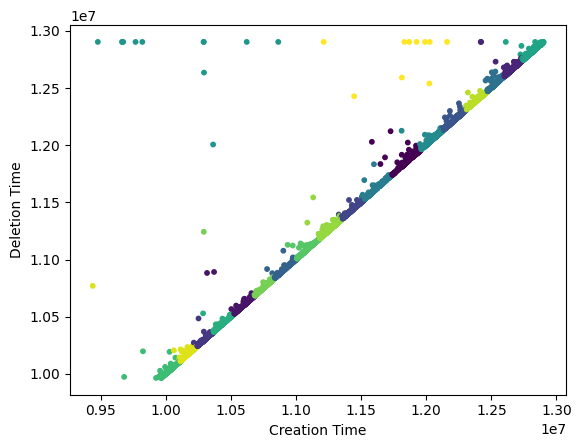

/home/fabing/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


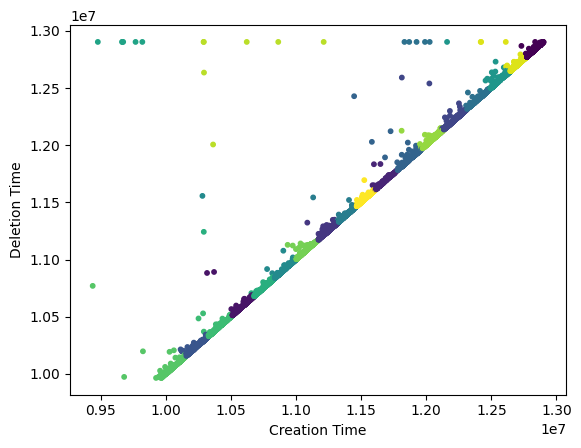

/home/fabing/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


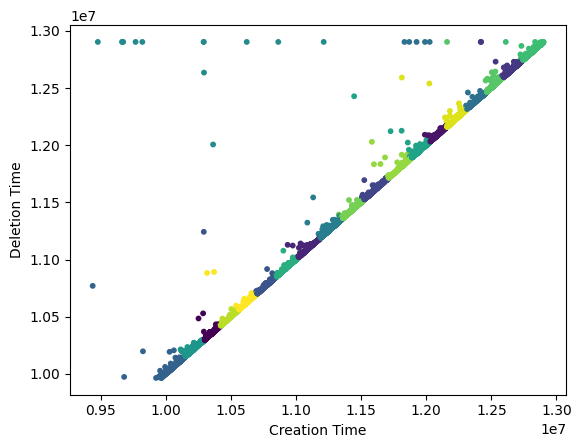

/home/fabing/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


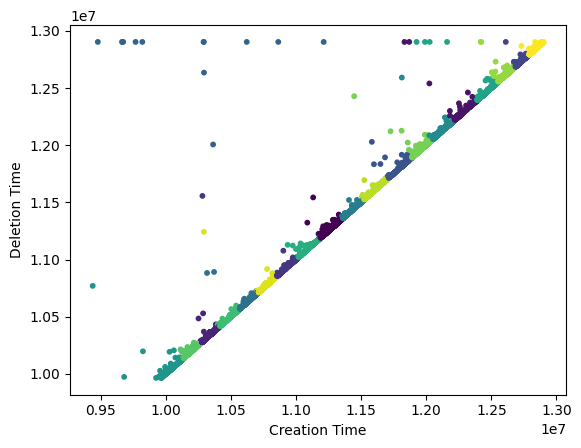

/home/fabing/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


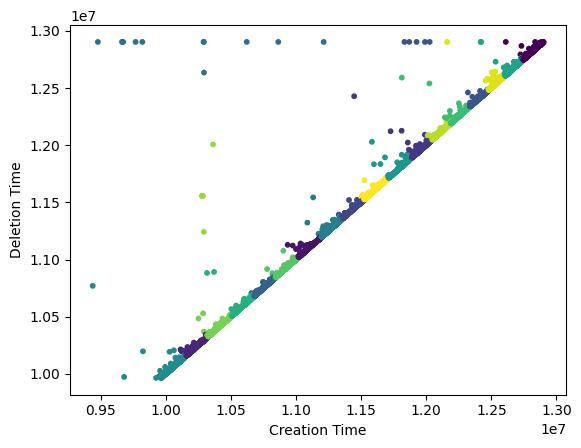

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans


traces = ['050', '100', '200', '250', '300']
for trace in traces:
    path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu{}.csv'.format(trace)
    df = pd.read_csv(path)
    data = df[df['creation_time'] > 9e6]
    # Prepare data for clustering
    X = data[['creation_time', 'deletion_time']]

    # Create a KMeans instance with the desired number of clusters
    kmeans = KMeans(n_clusters=20)

    # Fit the model to the data
    kmeans.fit(X)

    # Get the cluster assignments for each data point
    labels = kmeans.labels_

    # Plot the data points with colors representing their cluster assignments
    plt.scatter(data['creation_time'], data['deletion_time'], c=labels, s=10, cmap='viridis')

    plt.xlabel('Creation Time')
    plt.ylabel('Deletion Time')
    plt.show()
    # # plot the scatters of creation_time and deletion_time
    # plt.figure(figsize=(10, 5))
    # # plt.scatter(data['creation_time'], [1 for _ in range(len(data['creation_time']))], color='g', label=f'Trace {trace}')
    # # plt.scatter(data['deletion_time'], [2 for _ in range(len(data['deletion_time']))], color='r')
    # plt.scatter(data['creation_time'], data['deletion_time'], s=7, label=f'Trace {trace}')
    # plt.xlabel('Creation Time')
    # plt.ylabel('Deletion Time')
    # plt.legend()
    # plt.show()
    


collect the node used by each tenant

In [1]:
import pandas as pd

# Load the dataframe from the CSV file
path = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/2023_cpu/fabing_cpu_300_1_1/05-BestFit/1.3/42/analysis_price.csv'
with open(path, 'r') as f:
    line = f.readline()
    line = line.replace(r'\n', '')
    line = line.split(r',')
    print(len(line))
    print(line)

94
['openb-node-0628', 'openb-node-0155', 'openb-node-1055', 'openb-node-0492', 'openb-node-0051', 'openb-node-0009', 'openb-node-0016', 'openb-node-0508', 'openb-node-0119', 'openb-node-0540', 'openb-node-0161', 'openb-node-0562', 'openb-node-0897', 'openb-node-0143', 'openb-node-1141', 'openb-node-0967', 'openb-node-0381', 'openb-node-0010', 'openb-node-0949', 'openb-node-0896', 'openb-node-1140', 'openb-node-1168', 'openb-node-0604', 'openb-node-1142', 'openb-node-0767', 'openb-node-1051', 'openb-node-0630', 'openb-node-1146', 'openb-node-0436', 'openb-node-0335', 'openb-node-0475', 'openb-node-1080', 'openb-node-0713', 'openb-node-0479', 'openb-node-0563', 'openb-node-0572', 'openb-node-0292', 'openb-node-0194', 'openb-node-0862', 'openb-node-0271', 'openb-node-0870', 'openb-node-0454', 'openb-node-0162', 'openb-node-0655', 'openb-node-0990', 'openb-node-0989', 'openb-node-0379', 'openb-node-1059', 'openb-node-0431', 'openb-node-1076', 'openb-node-0145', 'openb-node-1138', 'openb-n

## cpu memory visualization

/tmp/ipykernel_1832983/2038392025.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


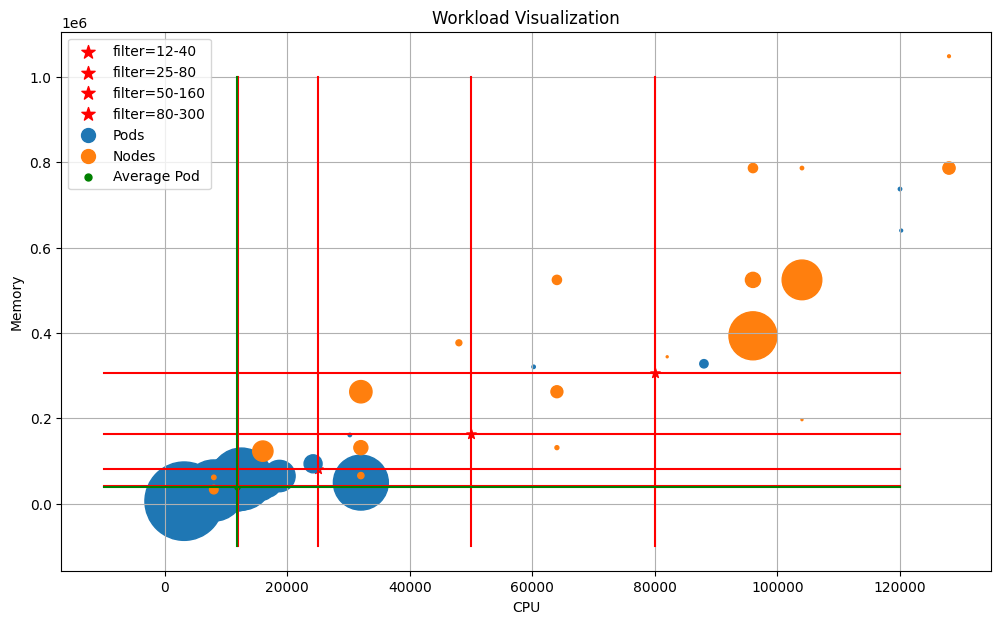

11833.258569447196 39404.213790370515


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu300.csv'
df = pd.read_csv(path)

avg_cpu = df['cpu_milli'].mean()
avg_mem = df['memory_mib'].mean()

node_path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_node_list_all_node.csv'
node_df = pd.read_csv(node_path)

X = df.groupby(['cpu_milli', 'memory_mib']).size().reset_index(name='counts')
X['size'] = X['counts'] * 2 
Y = node_df.groupby(['cpu_milli', 'memory_mib']).size().reset_index(name='counts')
Y['size'] = Y['counts'] * 2 
# kmeans = KMeans(n_clusters=1)
# kmeans.fit(X)
# center = kmeans.cluster_centers_
NUMBERS = ['1240', '2580', '50160', '80300']


plt.figure(figsize=(12, 7))  

for number in NUMBERS:
    cpu = int(number[:2]) * 1000
    memory = int(number[2:]) * 1024
    plt.scatter(cpu, memory, s=50, marker='*', color='r', label=f'filter={number[:2]}-{number[2:]}')
    plt.plot([cpu, cpu], [-1e5, 1e6], color='r')
    plt.plot([-1e4, 120000], [memory, memory], color='r')

plt.scatter(X['cpu_milli'], X['memory_mib'], s=X['size'], label='Pods')
plt.scatter(Y['cpu_milli'], Y['memory_mib'], s=Y['size'], label= 'Nodes')
plt.scatter(avg_cpu, avg_mem, s=50, marker='.', color='g', label='Average Pod')
# plt.scatter(center[0][0], center[0][1], s=50, marker='*', color='g', label='Center of Pods')
plt.plot([avg_cpu, avg_cpu], [-1e5, 1e6], color='g')
# plt.plot([2*avg_cpu, 2*avg_cpu], [-1e5, 1e6], color='g')
plt.plot([-1e4, 120000], [avg_mem, avg_mem], color='g')
# plt.plot([-1e4, 120000], [2*avg_mem, 2*avg_mem], color='g')
plt.xlabel('CPU')
plt.ylabel('Memory')
plt.title('Workload Visualization')
# 设置图例中标记的大小
legend = plt.legend()
plt.grid()
for handle in legend.legendHandles:
    handle._sizes = [100]  # 设置标记的大小，这里设置为100
plt.show()

# print(center)
print(avg_cpu, avg_mem)

In [7]:
import pandas as pd


path = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/2023_uniform_realtime/fabing_uniform_050_10_4/05-BestFit/1.3/42/analysis_time.csv'
df = pd.read_csv(path)

print(df['real_cpu'].values.tolist())


[12.0, 20.0, 36.0, 20.0, 28.0, 20.0, 32.0, 48.0, 32.0, 48.0, 59.91, 48.0, 32.0, 50.71, 32.0, 40.0, 32.0, 35.15, 32.0, 44.0, 32.0, 35.15, 43.15, 49.15, 67.86, 49.15, 43.15, 46.3, 43.15, 35.15, 23.15, 26.3, 23.15, 27.15, 23.15, 35.06, 23.15, 20.0, 31.91, 20.0, 23.15, 20.0, 31.91, 39.91, 31.91, 36.06, 24.15, 20.0, 32.0, 20.0, 36.0, 20.0, 31.91, 20.0, 23.15, 20.0, 23.15, 20.0, 36.0, 20.0, 28.0, 20.0, 28.0, 20.0, 24.0, 20.0, 26.0, 20.0, 28.0, 20.0, 23.15, 20.0, 26.0, 20.0, 28.0, 20.0, 31.4, 35.55, 41.55, 37.4, 31.4, 39.4, 43.4, 39.4, 28.0, 36.0, 28.0, 32.0, 28.0, 20.0, 28.0, 20.0, 31.91, 20.0, 23.15, 20.0, 23.15, 20.0, 28.0, 20.0, 23.15, 20.0, 23.15, 20.0, 23.15, 20.0, 26.0, 20.0, 24.0, 32.0, 24.0, 48.2, 24.0, 32.0, 28.0, 20.0, 24.0, 20.0, 23.15, 41.86, 23.15, 26.3, 23.15, 20.0, 38.71, 20.0, 28.0, 20.0, 24.0, 20.0, 24.0, 20.0, 24.15, 35.55, 46.95, 35.55, 24.15, 28.15, 31.3, 28.15, 24.15, 32.15, 24.15, 27.3, 24.15, 27.3, 24.15, 27.3, 24.15, 35.55, 24.15, 28.15, 24.15, 36.15, 48.06, 36.15, 24

## Generate the node list with same configurations
largest Nodes

In [14]:
import pandas as pd

# Load the dataframe from the CSV file
path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_node_list_all_node.csv'
out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_node_list_large_node.csv'
node_df = pd.read_csv(path)
print(path)

# Create an empty DataFrame with the same columns as node_df
new_df = pd.DataFrame(columns=node_df.columns)

# Get the row with the maximum 'cpu_milli'
max_cpu_row = node_df.loc[node_df['cpu_milli'].idxmax()]

# Append the row 400 times
prefix = 'openb-node-'
for idx in range(400):
    sn = f'{prefix}{str(idx).zfill(4)}'
    max_cpu_row['sn'] = sn
    new_df = pd.concat([new_df, max_cpu_row.to_frame().T])
    
# Reset the index
new_df = new_df.reset_index(drop=True)
print(new_df.head(2))
new_df.to_csv(out_file)

/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_node_list_all_node.csv
                sn cpu_milli memory_mib gpu model
0  openb-node-0000    128000     786432   8    G3
1  openb-node-0001    128000     786432   8    G3


/tmp/ipykernel_2106547/2090368193.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_cpu_row['sn'] = sn
/tmp/ipykernel_2106547/2090368193.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_cpu_row['sn'] = sn
/tmp/ipykernel_2106547/2090368193.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_cpu_row['sn'] = sn
/tmp/ipykernel_2106547/2090368193.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

# CDF-Utilization

## cluster_data

1 184.62797619047618 105.71883815939742
10 237.5 69.86353859656597
15 224.79166666666669 58.829026551456934
2 200.0 101.50312868693331
20 237.40625 48.54083103204827
3 215.26785714285714 97.86921846473523
5 258.875 101.60550943895294


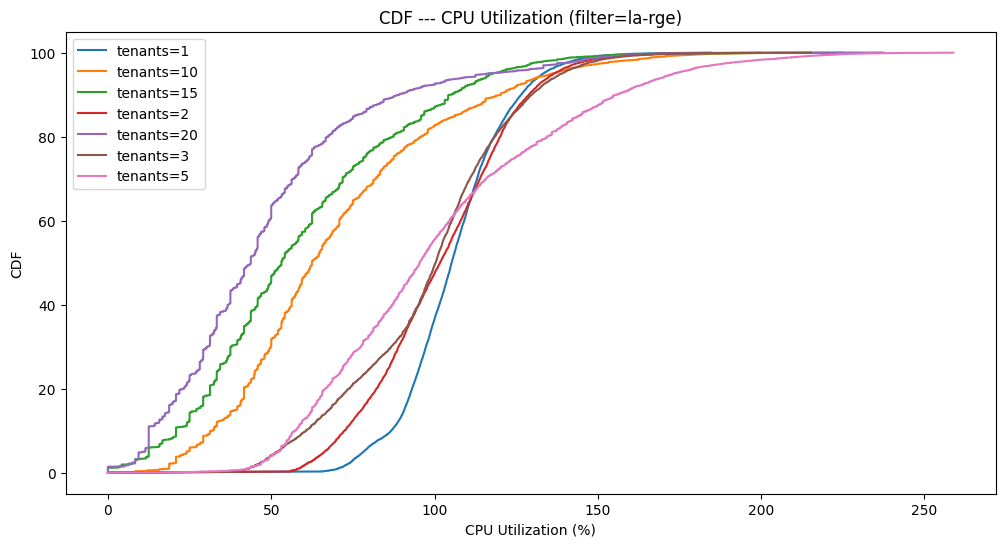

1 96.90690666666666 54.327811704643196
10 117.3916 25.748354614952632
15 112.43093333333333 21.604984791295628
2 90.01566315789474 43.17832138112292
20 111.11106666666667 18.112353526847564
3 119.52596363636363 44.599357083415576
5 117.9925 39.0482807937209


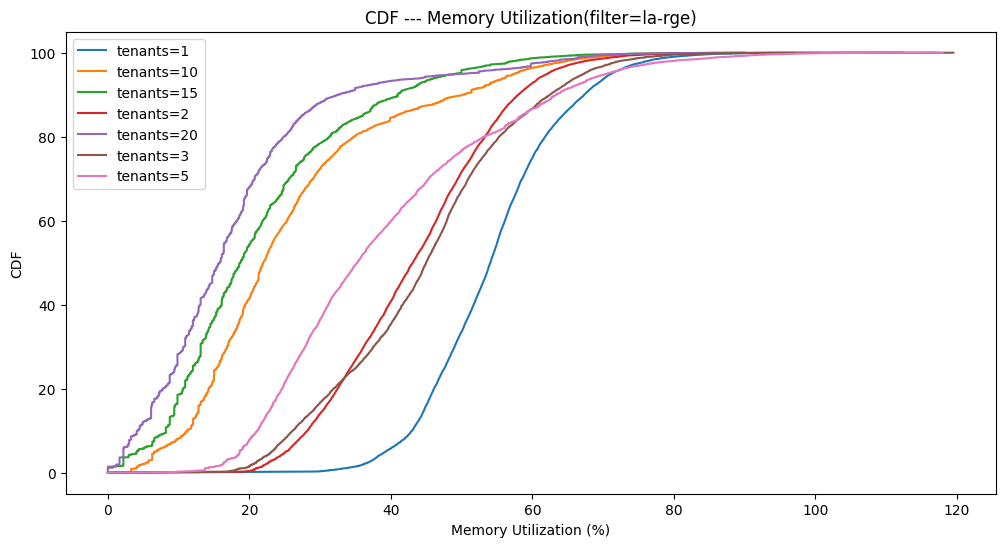

  filter tenants     max_cpu     avg_cpu     max_mem    avg_mem
0  large       1  184.627976  105.718838   96.906907  54.327812
1  large      10  237.500000   69.863539  117.391600  25.748355
2  large      15  224.791667   58.829027  112.430933  21.604985
3  large       2  200.000000  101.503129   90.015663  43.178321
4  large      20  237.406250   48.540831  111.111067  18.112354
5  large       3  215.267857   97.869218  119.525964  44.599357
6  large       5  258.875000  101.605509  117.992500  39.048281


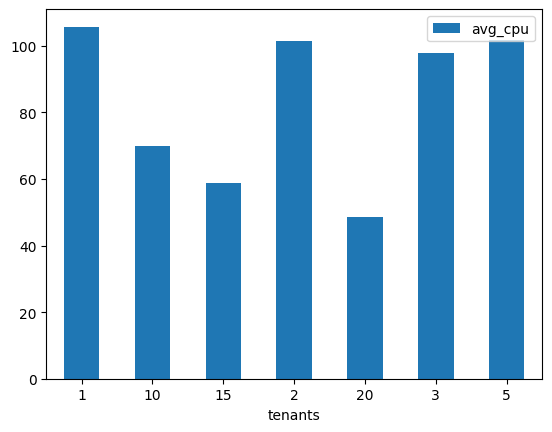

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p

NUMBERS = ['origin', '1240', '2580', '50160', '80300']
NUMBERS = ['large']
result_df = pd.DataFrame(columns=['filter', 'tenants', 'max_cpu', 'avg_cpu', 'max_mem', 'avg_mem'])
for num in NUMBERS:
    file = f'/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results_{num}/analysis_time_discrete.csv'
    # file = f'/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_time_discrete.csv'

    FILTER = 'fabing_uniform_300'
    # file = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_time_discrete.csv'
    df = pd.read_csv(file)
    # df = df[df['sc_policy']=='01-Random']
    df = df[df['sc_policy']=='05-BestFit']
    back_df = df.copy()
    # Extract the prefix of the 'workload' column
    df['workload_prefix'] = df['workload'].str.rsplit('_', n=1).str[0]
    # Calculate the average 'use_nodes' for each 'workload_prefix'
    df = df.groupby('workload_prefix').sum()
    df = df.reset_index()
    plt.figure(figsize=(12, 6))  # Change the numbers to fit your needs
    for i in df['workload_prefix'].unique():
        if not i.startswith(FILTER):
            continue
        data = []
        filtered_df = df[df['workload_prefix'] == i]
        paths = filtered_df['real'].values[0]
        for path in paths.split('.csv'):
            if path == '':
                continue
            real = pd.read_csv(path+'.csv')
            # use the tenant cpu capacity
            index = ''
            for s in path.split('/'):
                if 'fabing_uniform_' in s:
                    index = s
                    break
            capacity = back_df.loc[back_df['workload'] == index, 'cpu'].values[0] 
            data.extend(real['real_cpu'] / capacity * 100000)
        print(i.split('_')[-1], max(data), sum(data)/len(data))
        result_df.loc[len(result_df.index)] = [num, i.split('_')[-1], max(data), sum(data)/len(data), 0, 0]
        x, y = get_cdf(data)
        plt.plot(x, y, label='tenants={}'.format(i.split('_')[-1]))
    plt.legend()
    plt.xlabel('CPU Utilization (%)')
    plt.ylabel('CDF')
    plt.title(f'CDF --- CPU Utilization (filter={num[:2]}-{num[2:]})')
    plt.show()

    plt.figure(figsize=(12, 6))  # Change the numbers to fit your needs
    for i in df['workload_prefix'].unique():
        if not i.startswith(FILTER):
            continue
        data = []
        filtered_df = df[df['workload_prefix'] == i]
        paths = filtered_df['real'].values[0]
        for path in paths.split('.csv'):
            if path == '':
                continue
            real = pd.read_csv(path+'.csv')
            # use the tenant cpu capacity
            index = ''
            for s in path.split('/'):
                if 'fabing_uniform_' in s:
                    index = s
                    break
            capacity = back_df.loc[back_df['workload'] == index, 'mem'].values[0] 
            data.extend(real['real_memory'] / capacity * 1024 / 1e7)
        print(i.split('_')[-1], max(data), sum(data)/len(data))
        mask = (result_df['tenants'] == i.split('_')[-1]) & (result_df['filter'] == num)
        result_df.loc[mask, 'max_mem'] = max(data)
        result_df.loc[mask, 'avg_mem'] = sum(data)/len(data)
        x, y = get_cdf(data)
        plt.plot(x, y, label='tenants={}'.format(i.split('_')[-1]))
    plt.legend()
    plt.xlabel('Memory Utilization (%)')
    plt.ylabel('CDF')
    plt.title(f'CDF --- Memory Utilization(filter={num[:2]}-{num[2:]})')
    plt.show()
    
print(result_df)
result_df.to_csv('/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/utilization.csv', index=False)
# Assuming 'tenants' is the categorical variable and 'avg_cpu' is the numerical variable
result_df.plot.bar(x='tenants', y='avg_cpu', rot=0)
plt.show()

### analyze all utilization

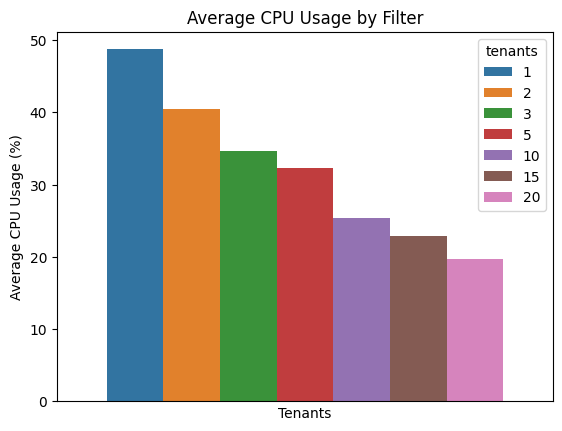

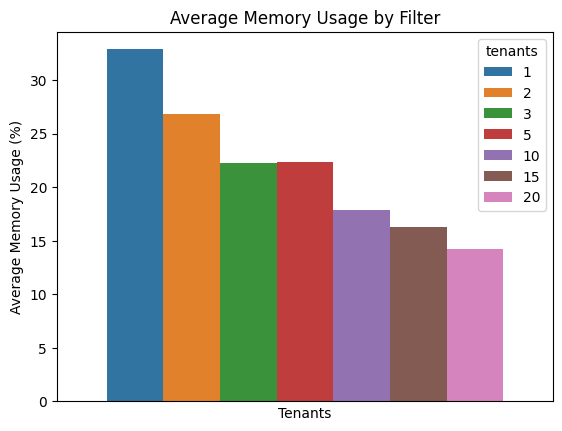

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

result_df = pd.read_csv('/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/utilization.csv')

# 使用 seaborn 来绘制带有 'tenants' 分组的条形图
sns.barplot(x='filter', y='avg_cpu', hue='tenants', data=result_df)

# 添加一些图表的细节，如标题和标签
plt.title('Average CPU Usage by Filter')
plt.xlabel('Tenants')
plt.ylabel('Average CPU Usage (%)')
plt.xticks([])

# 显示图表
plt.show()

# 使用 seaborn 来绘制带有 'tenants' 分组的条形图
sns.barplot(x='filter', y='avg_mem', hue='tenants', data=result_df)

# 添加一些图表的细节，如标题和标签
plt.title('Average Memory Usage by Filter')
plt.xlabel('Tenants')
plt.ylabel('Average Memory Usage (%)')
plt.xticks([])
# 显示图表
plt.show()


## philly trace analysis

['philly']
philly 95.54447268106735 41.25040257996464
philly-0e4a51 83.89739190116678 26.202635941646815
philly-103959 40.812917594654785 14.23529298116223
philly-11cb48 58.68581560283688 18.20891498123896
philly-23dbec 68.9609375 27.80575284090909
philly-2869ce 58.239837398373986 14.142523106510131
philly-51b7ef 100.0 15.061631944444445
philly-6214e9 94.89273224874563 26.432583968248487
philly-6c71a0 81.59594644849386 24.84921543375794
philly-795a4c 82.375 45.114583333333336
philly-7f04ca 83.49015748031496 23.826453080856275
philly-925e2b 69.53125 15.9296875
philly-b436b2 72.91918253599628 29.98865740030292
philly-e13805 50.96675531914894 17.883870429827986
philly-ed69ec 57.583204930662546 21.431011072772026
philly-ee9e8c 80.4971611071682 39.07185815979841


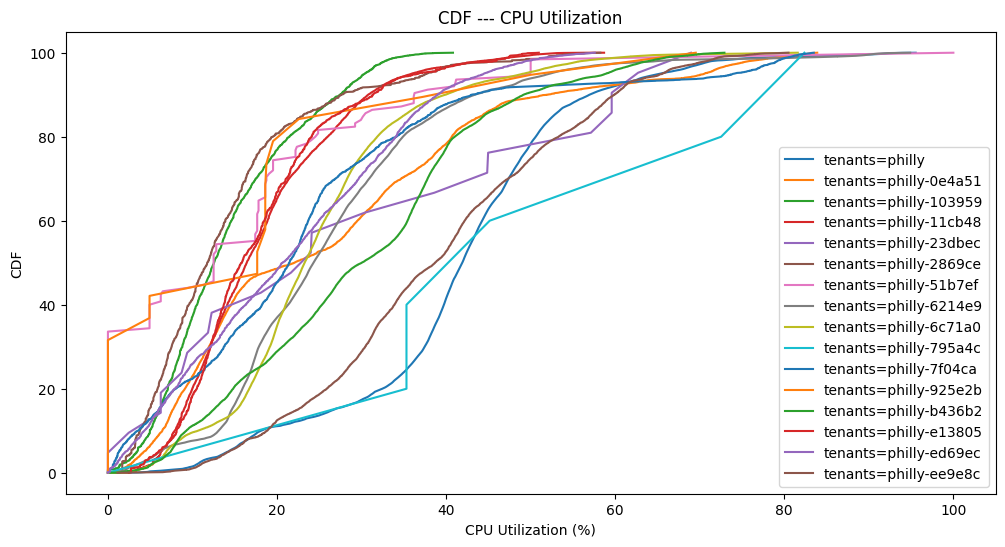

philly 52.73369414929388 24.53106227951288
philly-0e4a51 35.74336713091922 10.758495659345183
philly-103959 20.00991067961165 6.081366230508166
philly-11cb48 29.518638509316773 8.174660028314849
philly-23dbec 30.0927 12.040395454545454
philly-2869ce 25.320963855421684 6.96639045589268
philly-51b7ef 25.696 6.446258730158733
philly-6214e9 47.81936592592593 14.379346892436345
philly-6c71a0 32.83669701726844 11.022325412066753
philly-795a4c 40.7424 23.411199999999997
philly-7f04ca 34.40298246305419 9.926781224067327
philly-925e2b 21.2992 6.37344
philly-b436b2 28.66189507864028 14.189915959190879
philly-e13805 25.952802388059702 8.429506084032546
philly-ed69ec 29.361440261865795 10.091976222343026
philly-ee9e8c 36.347170996978846 17.22191795264416


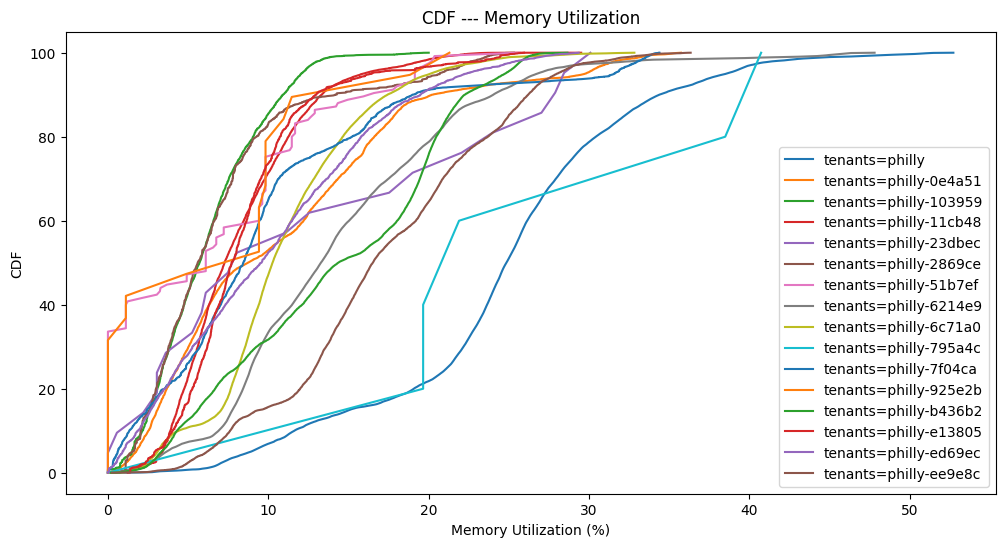

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p


file = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_time_discrete.csv'
df = pd.read_csv(file)
df['workload_prefix'] = df['workload'].str.rsplit('-', n=1).str[0]
print(df['workload_prefix'].unique())
back_df = df.copy()
# Extract the prefix of the 'workload' column
plt.figure(figsize=(12, 6))  # Change the numbers to fit your needs
for i in df['workload'].unique():
    data = []
    filtered_df = df[df['workload'] == i]
    paths = filtered_df['real'].values[0]
    for path in paths.split('.csv'):
        if path == '':
            continue
        real = pd.read_csv(path+'.csv')
        # use the tenant cpu capacity
        index = ''
        for s in path.split('/'):
            if 'philly' in s:
                index = s
                break
        capacity = back_df.loc[back_df['workload'] == index, 'cpu'].values[0] 
        data.extend(real['real_cpu'] / capacity * 100000)
    print(i, max(data), sum(data)/len(data))
    x, y = get_cdf(data)
    plt.plot(x, y, label='tenants={}'.format(i.split('_')[-1]))
plt.legend()
plt.xlabel('CPU Utilization (%)')
plt.ylabel('CDF')
plt.title('CDF --- CPU Utilization')
plt.show()

plt.figure(figsize=(12, 6))  # Change the numbers to fit your needs
for i in df['workload'].unique():
    data = []
    filtered_df = df[df['workload'] == i]
    paths = filtered_df['real'].values[0]
    for path in paths.split('.csv'):
        if path == '':
            continue
        real = pd.read_csv(path+'.csv')
        # use the tenant cpu capacity
        index = ''
        for s in path.split('/'):
            if 'philly' in s:
                index = s
                break
        capacity = back_df.loc[back_df['workload'] == index, 'mem'].values[0] 
        data.extend(real['real_memory'] / capacity * 1024 / 1e7)
    print(i, max(data), sum(data)/len(data))
    x, y = get_cdf(data)
    plt.plot(x, y, label='tenants={}'.format(i.split('_')[-1]))
plt.legend()
plt.xlabel('Memory Utilization (%)')
plt.ylabel('CDF')
plt.title('CDF --- Memory Utilization')
plt.show()



In [9]:
import pandas as pd

file = '/home/fabing/projects/kubernetes-scheduler-simulator/experiments/analysis/analysis_results/analysis_price_discrete.csv'
df = pd.read_csv(file)

print(df['used_nodes'].sum())
print(df['used_nodes'])


1149.0
0     290.0
1      86.0
2      19.0
3      34.0
4       4.0
5      18.0
6       2.0
7     247.0
8     147.0
9       1.0
10     60.0
11      2.0
12    114.0
13     16.0
14     33.0
15     76.0
Name: used_nodes, dtype: float64


# Generate Philly Trace for ours

In [4]:
import datetime

DATE_FORMAT_STR = '%Y-%m-%dT%H:%M:%SZ'
LOGDIR = '/home/fabing/projects/philly-traces/trace-data'

def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.datetime.strptime(date_str, DATE_FORMAT_STR)


class Job:
    """Encapsulates a job."""
    
    def __init__(self, status, vc, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               vc: The hash of the virtual cluster id the job was run in.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._vc = vc
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = self._attempts[-1]['end_time'] - self._attempts[0]['start_time']
                self._queueing_delay = self._attempts[0]['start_time'] - self._submitted_time
    
    @property
    def status(self):
        return self._status
    
    @property
    def vc(self):
        return self._vc
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time

## merge the trace

In [5]:
import os 
import json
import pandas as pd

path = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/openb_pod_list_cpu300.csv'
out_file = '/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/philly.csv'
df = pd.read_csv(path)
df['num_gpu'] = 0
df['gpu_milli'] = 0
df['gpu_spec'] = ''
cluster_job_log_path = os.path.join(LOGDIR, 'cluster_job_log')
with open(cluster_job_log_path, 'r') as f:
    cluster_job_log = json.load(f)
jobs = [Job(**job) for job in cluster_job_log]

# Create an empty dataframe 
new_df = pd.DataFrame(columns=df.columns)
length = len(df)
for idx, job in enumerate(jobs):
    if job.attempts and job.attempts[0]['start_time'] is not None and job.attempts[0]['end_time'] is not None:
        row = df.loc[idx%length].copy()
        row['creation_time'] = job.attempts[0]['start_time']
        row['deletion_time'] = job.attempts[-1]['end_time']
        row['name'] = job.jobid.replace('_', '-')
        row['vc'] = job.vc
        new_df = pd.concat([new_df, row.to_frame().T])

new_df.to_csv(out_file, index=False)
print(f'save to {out_file}')

# Group new_df by 'vc'
grouped = new_df.groupby('vc')

# Iterate over the groups
for vc, group_df in grouped:
    print(f"vc: {vc}")
    group_df.to_csv(f'/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/philly-{vc}.csv', index=False)


ValueError: time data '2017-10-09 07:02:05' does not match format '%Y-%m-%dT%H:%M:%SZ'

In [6]:
df = pd.read_csv('/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/philly.csv')
df['num_gpu'] = 0
df['gpu_milli'] = 0
df['gpu_spec'] = ''
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['deletion_time'] = pd.to_datetime(df['deletion_time'])

df['creation_time'] = df['creation_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
df['deletion_time'] = df['deletion_time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
df.to_csv(out_file, index=False)
print(f'save to {out_file}')

# Group new_df by 'vc'
grouped = df.groupby('vc')

# Iterate over the groups
for vc, group_df in grouped:
    print(f"vc: {vc}")
    group_df.to_csv(f'/home/fabing/projects/kubernetes-scheduler-simulator/data/csv/philly-{vc}.csv', index=False)



save to /home/fabing/projects/kubernetes-scheduler-simulator/data/csv/philly.csv
vc: 0e4a51
vc: 103959
vc: 11cb48
vc: 23dbec
vc: 2869ce
vc: 51b7ef
vc: 6214e9
vc: 6c71a0
vc: 795a4c
vc: 7f04ca
vc: 925e2b
vc: b436b2
vc: e13805
vc: ed69ec
vc: ee9e8c
